In [ ]:
import osmium as osm
import pandas as pd
import geopandas
import os.path
import os
import shapely.wkb as wkblib
wkbfab = osm.geom.WKBFactory()
import numpy as np
import shapely.geometry

from sklearn import tree
import graphviz
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import metrics
from sklearn.model_selection import cross_val_predict
from sklearn import preprocessing
import jenkspy
from sklearn.metrics import PrecisionRecallDisplay

In [ ]:
class AreaHandler(osm.SimpleHandler):
    def __init__(self):
        osm.SimpleHandler.__init__(self)
        self.num_polys = 0
        self.osm_data = []
        self.roads_data = []
        self.landuse_data = []
        self.amenity_data = []

    def count_polygons(self):
        self.num_polys += 1

    def way(self, w):
        try:
            wkb = wkbfab.create_linestring(w)
            line = wkblib.loads(wkb, hex=True)
            for tag in w.tags:
                if (tag.k=='highway'):
                    self.roads_data.append([w.id,
                                       tag.v,
                                       line])
        except Exception:
            pass

    def area(self, a):
        try:
            wkb = wkbfab.create_multipolygon(a)
            self.count_polygons()
            # load into shapely
            poly = wkblib.loads(wkb, hex=True)
            for tag in a.tags:
                if (tag.k=='building'):
                    self.osm_data.append([a.id,
                                    tag.v,
                                    list(poly.geoms)[0],
                                    list(dict(a.tags).keys()),
                                    dict(a.tags)])
                if (tag.k=='landuse'):
                    self.landuse_data.append([tag.v,
                                    list(poly.geoms)[0],
                                    ])
                if (tag.k == 'amenity'):
                    self.amenity_data.append([tag.v,
                                    list(poly.geoms)[0],
                                    ])
        except Exception:
            pass

In [ ]:
# load official buildings
# bhopal_shape.shp
buildings_path = "/DATA2/dse313/group15/Building Footprint Classification Data/Bhopal_Shape_file/bhopal_shape.shp"
official_buildings = geopandas.read_file(buildings_path)

In [ ]:
official_buildings.columns
official_buildings = official_buildings.sample(n = 25000)

In [ ]:
official_buildings = official_buildings.rename(columns={'type': 'official_type'})
official_buildings = official_buildings.rename(columns={'osm_id': 'OBJECTID'})
official_buildings = official_buildings.drop(columns = {'code', 'fclass', 'name'})

# changing "TYPE" -> 'type'
# changing "osm_id" -> "OBJECTID"
# drop columns "code", "fclass", "name"

In [ ]:
official_buildings.shape

(25000, 3)

In [ ]:
official_buildings.groupby(['official_type']).count()

,OBJECTID,geometry
official_type,,
apartments,4,4
commercial,1,1
house,10,10
industrial,4,4
residential,2,2
roof,1,1
school,1,1
shed,1,1
storage_tank,6,6


In [ ]:
len(official_buildings['OBJECTID'].unique())

25000

In [ ]:
official_buildings.drop(official_buildings[(official_buildings['official_type'] == 'MG') \
                                   | (official_buildings['official_type'] == 'O') \
                                   | (official_buildings['official_type'] == 'MH') \
                                   | (official_buildings['official_type'] == 'MU')].index, inplace = True)

official_buildings.reset_index(inplace=True, drop=True)

In [ ]:
official_buildings.groupby(['official_type']).count()

,OBJECTID,geometry
official_type,,
apartments,4,4
commercial,1,1
house,10,10
industrial,4,4
residential,2,2
roof,1,1
school,1,1
shed,1,1
storage_tank,6,6


In [ ]:
official_buildings.shape

(25000, 3)

In [ ]:
official_buildings['official_type'] = official_buildings['official_type'].apply(\
                                lambda x: 'RES' if (x == 'SFR' \
                                                    or x == 'MFR') else 'NON_RES')

In [ ]:
official_buildings.groupby('official_type').count()

,OBJECTID,geometry
official_type,,
NON_RES,25000,25000


In [ ]:
#====================================================================================#
#====================================================================================#

In [ ]:
areahandler = AreaHandler()
areahandler.apply_file("/DATA2/dse313/group15/Building Footprint Classification Data/central_zone_latest.osm.pbf", locations=True)
print("Number of polygons: %d" % areahandler.num_polys)

Number of polygons: 3262506


In [ ]:
len(areahandler.osm_data)

3024424

In [ ]:
# transform the list into a pandas DataFrame
data_colnames = ['id', 'building', 'geometry', 'all_tag_keys', 'all_tags']
df = pd.DataFrame(areahandler.osm_data, columns=data_colnames)

In [ ]:
df.head()

,id,building,geometry,all_tag_keys,all_tags
0,53296690,yes,"POLYGON ((82.8535498 25.4498294, 82.853574 25....","[aeroway, building]","{'aeroway': 'hangar', 'building': 'yes'}"
1,53298932,yes,"POLYGON ((83.1250321 25.2782076, 83.1250579 25...","[building, man_made]","{'building': 'yes', 'man_made': 'water_tower'}"
2,53299138,yes,"POLYGON ((83.1229722 25.2794727, 83.1229979 25...","[building, man_made]","{'building': 'yes', 'man_made': 'water_tower'}"
3,53301904,yes,"POLYGON ((83.1046692 25.2777169, 83.1047722 25...",[building],{'building': 'yes'}
4,53363890,yes,"POLYGON ((82.9957182 25.2659781, 82.9957677 25...","[addr:city, area, building, layer, leisure, name]","{'addr:city': 'Varanasi', 'area': 'yes', 'buil..."


In [ ]:
gdf = geopandas.GeoDataFrame(df, crs=4326, geometry='geometry')

<Axes: >

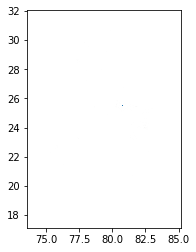

In [ ]:
gdf.plot()


In [ ]:
gdf.head()

,id,building,geometry,all_tag_keys,all_tags
0,53296690,yes,"POLYGON ((82.85355 25.44983, 82.85357 25.44975...","[aeroway, building]","{'aeroway': 'hangar', 'building': 'yes'}"
1,53298932,yes,"POLYGON ((83.12503 25.27821, 83.12506 25.27816...","[building, man_made]","{'building': 'yes', 'man_made': 'water_tower'}"
2,53299138,yes,"POLYGON ((83.12297 25.27947, 83.12300 25.27943...","[building, man_made]","{'building': 'yes', 'man_made': 'water_tower'}"
3,53301904,yes,"POLYGON ((83.10467 25.27772, 83.10477 25.27767...",[building],{'building': 'yes'}
4,53363890,yes,"POLYGON ((82.99572 25.26598, 82.99577 25.26587...","[addr:city, area, building, layer, leisure, name]","{'addr:city': 'Varanasi', 'area': 'yes', 'buil..."


In [ ]:
gdf.groupby('building').count().sort_values(by=['building'], inplace=False, ascending=True)

,id,geometry,all_tag_keys,all_tags
building,,,,
Madari,1,1,1,1
Place_of_worship,1,1,1,1
Private,1,1,1,1
SC,1,1,1,1
Temple Grounds,1,1,1,1
...,...,...,...,...
warter tank,6,6,6,6
watch_tower,7,7,7,7
water_tower,19,19,19,19


In [ ]:
# transform the list into a pandas DataFrame
land_colnames = ['landuse', 'geometry']
land_df = pd.DataFrame(areahandler.landuse_data, columns=land_colnames)

In [ ]:
land_df.shape

(114292, 2)

In [ ]:
land_df.head()

,landuse,geometry
0,residential,"POLYGON ((78.1839918 22.691056, 78.1897627 22...."
1,residential,"POLYGON ((80.5695113 24.5754455, 80.5699554 24..."
2,residential,"POLYGON ((78.8039322 25.5714169, 78.8048322 25..."
3,residential,"POLYGON ((84.1301522 25.7530799, 84.1316788 25..."
4,residential,"POLYGON ((83.848255 25.858557, 83.849155 25.85..."


In [ ]:
land_df.groupby('landuse').count()

,geometry
landuse,
Triangular Part,1
agriculture,4
allotments,7
apartments,1
aquaculture,10
basin,714
brownfield,14
cemetery,44
churchyard,1


In [ ]:
non_res = ['commercial', 'retail','industrial','grass','plant_nursery','quarry','railway','government',\
            'institutional']
land_df['landuse'] = land_df['landuse'].apply(\
                                lambda x: 'non_res' if x in non_res else x)

In [ ]:
land_df.groupby('landuse').count()

,geometry
landuse,
Triangular Part,1
agriculture,4
allotments,7
apartments,1
aquaculture,10
basin,714
brownfield,14
cemetery,44
churchyard,1


In [ ]:
land_gdf = geopandas.GeoDataFrame(land_df, crs=4326, geometry='geometry')

In [ ]:
gdf.shape

(3024424, 5)

In [ ]:
land_gdf.shape

(114292, 2)

In [ ]:
buildings_land = gdf.sjoin(land_gdf, how="left", predicate='intersects')

In [ ]:
buildings_land.shape

(3095982, 7)

In [ ]:
buildings_land.drop_duplicates(subset='id',inplace=True)

In [ ]:
buildings_land.shape

(3024424, 7)

In [ ]:
buildings_land.head()

,id,building,geometry,all_tag_keys,all_tags,index_right,landuse
0,53296690,yes,"POLYGON ((82.85355 25.44983, 82.85357 25.44975...","[aeroway, building]","{'aeroway': 'hangar', 'building': 'yes'}",NaN,NaN
1,53298932,yes,"POLYGON ((83.12503 25.27821, 83.12506 25.27816...","[building, man_made]","{'building': 'yes', 'man_made': 'water_tower'}",42016.0,residential
2,53299138,yes,"POLYGON ((83.12297 25.27947, 83.12300 25.27943...","[building, man_made]","{'building': 'yes', 'man_made': 'water_tower'}",42016.0,residential
3,53301904,yes,"POLYGON ((83.10467 25.27772, 83.10477 25.27767...",[building],{'building': 'yes'},42016.0,residential
4,53363890,yes,"POLYGON ((82.99572 25.26598, 82.99577 25.26587...","[addr:city, area, building, layer, leisure, name]","{'addr:city': 'Varanasi', 'area': 'yes', 'buil...",NaN,NaN


In [ ]:
buildings_land.rename(columns={'index_right': 'index_landuse'},inplace=True)
buildings_land['landuse'] = \
            buildings_land['landuse'].apply(lambda x: 'no_landuse' if pd.isnull(x) else x)
buildings_land.reset_index(inplace=True, drop=True)

In [ ]:
buildings_land[buildings_land['landuse'] == 'no_landuse'].shape

(2333787, 7)

In [ ]:
len(buildings_land.index_landuse.unique())

10029

In [ ]:
buildings_land.head()

,id,building,geometry,all_tag_keys,all_tags,index_landuse,landuse
0,53296690,yes,"POLYGON ((82.85355 25.44983, 82.85357 25.44975...","[aeroway, building]","{'aeroway': 'hangar', 'building': 'yes'}",NaN,no_landuse
1,53298932,yes,"POLYGON ((83.12503 25.27821, 83.12506 25.27816...","[building, man_made]","{'building': 'yes', 'man_made': 'water_tower'}",42016.0,residential
2,53299138,yes,"POLYGON ((83.12297 25.27947, 83.12300 25.27943...","[building, man_made]","{'building': 'yes', 'man_made': 'water_tower'}",42016.0,residential
3,53301904,yes,"POLYGON ((83.10467 25.27772, 83.10477 25.27767...",[building],{'building': 'yes'},42016.0,residential
4,53363890,yes,"POLYGON ((82.99572 25.26598, 82.99577 25.26587...","[addr:city, area, building, layer, leisure, name]","{'addr:city': 'Varanasi', 'area': 'yes', 'buil...",NaN,no_landuse


In [ ]:
buildings_land.groupby('landuse').count()

,id,building,geometry,all_tag_keys,all_tags,index_landuse
landuse,,,,,,
agriculture,45,45,45,45,45,45
allotments,40,40,40,40,40,40
aquaculture,2,2,2,2,2,2
basin,49,49,49,49,49,49
cemetery,46,46,46,46,46,46
churchyard,4,4,4,4,4,4
come,30,30,30,30,30,30
construction,124,124,124,124,124,124
dam,2,2,2,2,2,2


In [ ]:
buildings_land.groupby(['landuse','building']).count().head(50)

id  geometry  all_tag_keys  all_tags  \
landuse      building                                                          
agriculture  yes                        45        45            45        45   
allotments   service                     1         1             1         1   
             shed                       26        26            26        26   
             yes                        13        13            13        13   
aquaculture  yes                         2         2             2         2   
basin        industrial                  6         6             6         6   
             yes                        43        43            43        43   
cemetery     house                       1         1             1         1   
             yes                        45        45            45        45   
churchyard   church                      3         3             3         3   
             yes                         1         1             1         1   
come         yes                        30        30            30        30   
construction construction                3         3             3         3   
             house                      15        15            15        15   
             industrial                  2         2             2         2   
             shed                        1         1             1         1   
             warehouse                   6         6             6         6   
             yes                        97        97            97        97   
dam          yes                         2         2             2         2   
depot        yes                         3         3             3         3   
education    college                    17        17            17        17   
             school                      2         2             2         2   
             students_workplace_lab      1         1             1         1   
             university                  2         2             2         2   
             yes                       746       746           746       746   
farmland     apartments                  6         6             6         6   
             chapel                      1         1             1         1   
             commercial                  3         3             3         3   
             construction               16        16            16        16   
             farm_auxiliary              3         3             3         3   
             house                     353       353           353       353   
             hut                        11        11            11        11   
             industrial                  3         3             3         3   
             no                          1         1             1         1   
             public                      1         1             1         1   
             residential                 7         7             7         7   
             ruins                       1         1             1         1   
             school                      7         7             7         7   
             terrace                     1         1             1         1   
             yes                     15663     15663         15663     15663   
farmyard     house                      18        18            18        18   
             yes                       288       288           288       288   
field        yes                         1         1             1         1   
forest       Temple Grounds              1         1             1         1   
             construction                2         2             2         2   
             house                      87        87            87        87   
             hut                         1         1             1         1   
             industrial                  1         1             1         1   
             public                     

In [ ]:
buildings_land['land_building'] = buildings_land.apply(lambda x: \
    x['landuse'] if x['building'] == 'yes' else x['building'], axis=1)

In [ ]:
buildings_land.groupby(['landuse','land_building']).count().head(50)

id  building  geometry  all_tag_keys  \
landuse      land_building                                                     
agriculture  agriculture                45        45        45            45   
allotments   allotments                 13        13        13            13   
             service                     1         1         1             1   
             shed                       26        26        26            26   
aquaculture  aquaculture                 2         2         2             2   
basin        basin                      43        43        43            43   
             industrial                  6         6         6             6   
cemetery     cemetery                   45        45        45            45   
             house                       1         1         1             1   
churchyard   church                      3         3         3             3   
             churchyard                  1         1         1             1   
come         come                       30        30        30            30   
construction construction              100       100       100           100   
             house                      15        15        15            15   
             industrial                  2         2         2             2   
             shed                        1         1         1             1   
             warehouse                   6         6         6             6   
dam          dam                         2         2         2             2   
depot        depot                       3         3         3             3   
education    college                    17        17        17            17   
             education                 746       746       746           746   
             school                      2         2         2             2   
             students_workplace_lab      1         1         1             1   
             university                  2         2         2             2   
farmland     apartments                  6         6         6             6   
             chapel                      1         1         1             1   
             commercial                  3         3         3             3   
             construction               16        16        16            16   
             farm_auxiliary              3         3         3             3   
             farmland                15663     15663     15663         15663   
             house                     353       353       353           353   
             hut                        11        11        11            11   
             industrial                  3         3         3             3   
             no                          1         1         1             1   
             public                      1         1         1             1   
             residential                 7         7         7             7   
             ruins                       1         1         1             1   
             school                      7         7         7             7   
             terrace                     1         1         1             1   
farmyard     farmyard                  288       288       288           288   
             house                      18        18        18            18   
field        field                       1         1         1             1   
forest       Temple Grounds              1         1         1             1   
             construction                2         2         2             2   
             forest                   1624      1624      1624          1624   
             house                      87        87        87            87   
             hut                         1         1         1             1   
             industrial                  1         1         1             1   
             public                     

In [ ]:
buildings_land.groupby(['landuse','land_building']).count().tail(50)

id  building  geometry  all_tag_keys  \
landuse       land_building                                              
religious     temple               2         2         2             2   
reservoir     reservoir           20        20        20            20   
residential   Private              1         1         1             1   
              apartments        1366      1366      1366          1366   
              barn                 4         4         4             4   
              church               4         4         4             4   
              college             40        40        40            40   
              commercial          91        91        91            91   
              construction        79        79        79            79   
              detached            12        12        12            12   
              dormitory           67        67        67            67   
              farm                 3         3         3             3   
              garage              16        16        16            16   
              government           3         3         3             3   
              grandstand           1         1         1             1   
              hospital           102       102       102           102   
              hotel               28        28        28            28   
              house             5538      5538      5538          5538   
              hut                 11        11        11            11   
              industrial          61        61        61            61   
              kindergarten         2         2         2             2   
              manufacture          1         1         1             1   
              mosque               6         6         6             6   
              office               6         6         6             6   
              public              14        14        14            14   
              residential     620992    620992    620992        620992   
              retail              20        20        20            20   
              roof                23        23        23            23   
              ruins               15        15        15            15   
              school             129       129       129           129   
              service              1         1         1             1   
              shed               155       155       155           155   
              shop                 2         2         2             2   
              sports_hall          1         1         1             1   
              stable              16        16        16            16   
              stadium             21        21        21            21   
              storage_tank         1         1         1             1   
              temple              42        42        42            42   
              terrace            942       942       942           942   
              train_station       21        21        21            21   
              transportation       8         8         8             8   
              university          10        10        10            10   
              wall                 1         1         1             1   
              walls                1         1         1             1   
              warehouse            4         4         4             4   
              warter tank          2         2         2             2   
university    stadium              1         1         1             1   
              university           9         9         9             9   
village_green village_green        1         1         1             1   
yes           house                1         1         1             1   

                              all_tags  index_landuse  
landuse       land_building                            
religious     temple                 2              2  
reservoir     res

In [ ]:
def enrich_buildings(buildings_land,tags_list):
    for tag_val in tags_list:
        buildings_land['land_building'] = buildings_land.apply(lambda x: \
            tag_val if x['landuse'] == tag_val else x['land_building'], axis=1)

    return buildings_land

In [ ]:
tags_list = ['residential','commercial','religious','recreation_ground','cemetery',\
            'construction','farmland','farmyard','forest','military']
buildings_land = enrich_buildings(buildings_land,tags_list)

In [ ]:
buildings_land.groupby(['landuse','land_building']).count().head(50)

id  building  geometry  \
landuse                 land_building                                        
agriculture             agriculture                 45        45        45   
allotments              allotments                  13        13        13   
                        service                      1         1         1   
                        shed                        26        26        26   
aquaculture             aquaculture                  2         2         2   
basin                   basin                       43        43        43   
                        industrial                   6         6         6   
cemetery                cemetery                    46        46        46   
churchyard              church                       3         3         3   
                        churchyard                   1         1         1   
come                    come                        30        30        30   
construction            construction               124       124       124   
dam                     dam                          2         2         2   
depot                   depot                        3         3         3   
education               college                     17        17        17   
                        education                  746       746       746   
                        school                       2         2         2   
                        students_workplace_lab       1         1         1   
                        university                   2         2         2   
farmland                farmland                 16077     16077     16077   
farmyard                farmyard                   306       306       306   
field                   field                        1         1         1   
forest                  forest                    1723      1723      1723   
garages                 garages                     63        63        63   
                        industrial                   3         3         3   
greenfield              greenfield                  20        20        20   
                        house                        4         4         4   
greenhouse_horticulture greenhouse_horticulture     54        54        54   
landfill                landfill                    23        23        23   
meadow                  commercial                   1         1         1   
                        house                        4         4         4   
                        industrial                   1         1         1   
                        meadow                     116       116       116   
                        ruins                        6         6         6   
military                military                  6073      6073      6073   
mixed                   mixed                       36        36        36   
no_landuse              Madari                       1         1         1   
                        Place_of_worship             1         1         1   
                        SC                           1         1         1   
                        Walled_Area                  1         1         1   
                        apartments                1080      1080      1080   
                        barn                         6         6         6   
                        boathouse                    1         1         1   
                        cabin                        3         3         3   
                        carport                      4         4         4   
                        chapel                       1         1         1   
                        church                      12        12        12   
                        civic                        1         1         1   
                        college                    179       179       179   
                        commercial                 283       283       283

In [ ]:
buildings_land.groupby(['landuse','land_building']).count().tail(50)

id  building  geometry  all_tag_keys  \
landuse           land_building                                                 
no_landuse        watch_tower             7         7         7             7   
                  water_tower            16        16        16            16   
                  workshop                1         1         1             1   
non_res           apartments             28        28        28            28   
                  church                  1         1         1             1   
                  college                 3         3         3             3   
                  commercial             72        72        72            72   
                  construction            1         1         1             1   
                  dormitory               1         1         1             1   
                  factory                 4         4         4             4   
                  gabled                  5         5         5             5   
                  garage                  3         3         3             3   
                  garages                 1         1         1             1   
                  gasometer               4         4         4             4   
                  guardhouse              3         3         3             3   
                  historic                1         1         1             1   
                  hospital                3         3         3             3   
                  hotel                   4         4         4             4   
                  house                  21        21        21            21   
                  hut                     1         1         1             1   
                  industrial           1730      1730      1730          1730   
                  kindergarten            1         1         1             1   
                  monument                1         1         1             1   
                  non_res             31372     31372     31372         31372   
                  office                 27        27        27            27   
                  residential             8         8         8             8   
                  retail                  7         7         7             7   
                  roof                   56        56        56            56   
                  school                 27        27        27            27   
                  service               166       166       166           166   
                  shed                    8         8         8             8   
                  silo                    1         1         1             1   
                  storage_tank          758       758       758           758   
                  temple                  1         1         1             1   
                  train_station          72        72        72            72   
                  transportation          5         5         5             5   
                  university              1         1         1             1   
                  warehouse              44        44        44            44   
                  water_tower             3         3         3             3   
orchard           college                 1         1         1             1   
                  orchard                10        10        10            10   
prison            prison                274       274       274           274   
recreation_ground recreation_ground     123       123       123           123   
religious         religious             266       266       266           266   
reservoir         reservoir              20        20        20            20   
residential       residential        629863    629863    629863        629863   
university        stadium                 1         1         1             1   
                  university              9         9         9         

In [ ]:
buildings_land.groupby(['land_building']).count().head(50)

,id,building,geometry,all_tag_keys,all_tags,index_landuse,landuse
land_building,,,,,,,
Madari,1,1,1,1,1,0,1
Place_of_worship,1,1,1,1,1,0,1
SC,1,1,1,1,1,0,1
Walled_Area,1,1,1,1,1,0,1
agriculture,45,45,45,45,45,45,45
allotments,13,13,13,13,13,13,13
apartments,1108,1108,1108,1108,1108,28,1108
aquaculture,2,2,2,2,2,2,2
barn,6,6,6,6,6,0,6


In [ ]:
buildings_land.shape

(3024424, 8)

In [ ]:
official_buildings.shape

(25000, 3)

In [ ]:
buildings_gdf = buildings_land.sjoin(official_buildings, how="inner", predicate='intersects')
buildings_gdf.rename(columns={'index_right': 'index_official'}, inplace=True)

In [ ]:
buildings_gdf.shape

(25509, 11)

In [ ]:
buildings_gdf

,id,building,geometry,all_tag_keys,all_tags,index_landuse,landuse,land_building,index_official,OBJECTID,official_type
19692,602266546,industrial,"POLYGON ((77.41015 23.27884, 77.41057 23.27876...","[building, name]","{'building': 'industrial', 'name': 'BHC Waste ...",28340.0,residential,residential,20753,301133273,NON_RES
19693,602266548,industrial,"POLYGON ((77.40992 23.28095, 77.41010 23.28078...","[building, name]","{'building': 'industrial', 'name': 'Sevin stru...",28340.0,residential,residential,4767,652167117,NON_RES
391863,1304334234,industrial,"POLYGON ((77.40989 23.28106, 77.40996 23.28100...",[building],{'building': 'industrial'},28340.0,residential,residential,4767,652167117,NON_RES
19696,602266560,industrial,"POLYGON ((77.40663 23.27965, 77.40700 23.27960...",[building],{'building': 'industrial'},28340.0,residential,residential,15060,301133280,NON_RES
121625,719641052,yes,"POLYGON ((77.43047 23.23162, 77.43056 23.23118...","[building, name]","{'building': 'yes', 'name': 'Vyapam'}",16615.0,non_res,non_res,21485,359820526,NON_RES
...,...,...,...,...,...,...,...,...,...,...,...
2993468,2379133804,yes,"POLYGON ((77.48820 23.25170, 77.48831 23.25158...","[building, source]","{'building': 'yes', 'source': 'microsoft/Build...",30129.0,residential,residential,24425,1189566902,NON_RES
2993469,2379133806,yes,"POLYGON ((77.48854 23.25135, 77.48856 23.25121...","[building, source]","{'building': 'yes', 'source': 'microsoft/Build...",30129.0,residential,residential,12923,1189566903,NON_RES
2996467,2403024026,house,"POLYGON ((77.39841 23.22300, 77.39854 23.22296...",[building],{'building': 'house'},27962.0,residential,residential,12130,1201512013,NON_RES
2996470,2403024034,residential,"POLYGON ((77.40083 23.22071, 77.40099 23.22072...",[building],{'building': 'residential'},27962.0,residential,residential,6562,1201512017,NON_RES


In [ ]:
buildings_gdf.drop_duplicates(subset='id',inplace=True)

In [ ]:
buildings_gdf.shape

(25411, 11)

In [ ]:
buildings_gdf.groupby(['landuse','land_building','official_type',]).count().head(50)

id  building  geometry  \
landuse           land_building     official_type                              
farmland          farmland          NON_RES            9         9         9   
military          military          NON_RES           61        61        61   
no_landuse        apartments        NON_RES            1         1         1   
                  commercial        NON_RES            1         1         1   
                  hospital          NON_RES            1         1         1   
                  house             NON_RES            1         1         1   
                  no_landuse        NON_RES         9786      9786      9786   
                  school            NON_RES            2         2         2   
                  shed              NON_RES            1         1         1   
                  university        NON_RES            2         2         2   
non_res           industrial        NON_RES            1         1         1   
                  non_res           NON_RES          209       209       209   
                  storage_tank      NON_RES            6         6         6   
                  transportation    NON_RES            2         2         2   
recreation_ground recreation_ground NON_RES            1         1         1   
residential       residential       NON_RES        15327     15327     15327   

                                                   all_tag_keys  all_tags  \
landuse           land_building     official_type                           
farmland          farmland          NON_RES                   9         9   
military          military          NON_RES                  61        61   
no_landuse        apartments        NON_RES                   1         1   
                  commercial        NON_RES                   1         1   
                  hospital          NON_RES                   1         1   
                  house             NON_RES                   1         1   
                  no_landuse        NON_RES                9786      9786   
                  school            NON_RES                   2         2   
                  shed              NON_RES                   1         1   
                  university        NON_RES                   2         2   
non_res           industrial        NON_RES                   1         1   
                  non_res           NON_RES                 209       209   
                  storage_tank      NON_RES                   6         6   
                  transportation    NON_RES                   2         2   
recreation_ground recreation_ground NON_RES                   1         1   
residential       residential       NON_RES               15327     15327   

                                                   index_landuse  \
landuse           land_building     official_type                  
farmland          farmland          NON_RES                    9   
military          military          NON_RES                   61   
no_landuse        apartments        NON_RES                    0   
                  commercial        NON_RES                    0   
                  hospital          NON_RES                    0   
                  house             NON_RES                    0   
                  no_landuse        NON_RES                    0   
                  school            NON_RES                    0   
                  shed              NON_RES                    0   
                  university        NON_RES                    0   
non_res           industrial        NON_RES                    1   
                  non_res           NON_RES                  209   
                  storage_tank      NON_RES                    6   
                  transportation    NON_RES                    2   
recreation_ground recreation_ground NON_RES                    1   
residential       residential       NON_RES                15327   

 

In [ ]:
buildings_gdf.groupby(['landuse','land_building','official_type',]).count().tail(50)

id  building  geometry  \
landuse           land_building     official_type                              
farmland          farmland          NON_RES            9         9         9   
military          military          NON_RES           61        61        61   
no_landuse        apartments        NON_RES            1         1         1   
                  commercial        NON_RES            1         1         1   
                  hospital          NON_RES            1         1         1   
                  house             NON_RES            1         1         1   
                  no_landuse        NON_RES         9786      9786      9786   
                  school            NON_RES            2         2         2   
                  shed              NON_RES            1         1         1   
                  university        NON_RES            2         2         2   
non_res           industrial        NON_RES            1         1         1   
                  non_res           NON_RES          209       209       209   
                  storage_tank      NON_RES            6         6         6   
                  transportation    NON_RES            2         2         2   
recreation_ground recreation_ground NON_RES            1         1         1   
residential       residential       NON_RES        15327     15327     15327   

                                                   all_tag_keys  all_tags  \
landuse           land_building     official_type                           
farmland          farmland          NON_RES                   9         9   
military          military          NON_RES                  61        61   
no_landuse        apartments        NON_RES                   1         1   
                  commercial        NON_RES                   1         1   
                  hospital          NON_RES                   1         1   
                  house             NON_RES                   1         1   
                  no_landuse        NON_RES                9786      9786   
                  school            NON_RES                   2         2   
                  shed              NON_RES                   1         1   
                  university        NON_RES                   2         2   
non_res           industrial        NON_RES                   1         1   
                  non_res           NON_RES                 209       209   
                  storage_tank      NON_RES                   6         6   
                  transportation    NON_RES                   2         2   
recreation_ground recreation_ground NON_RES                   1         1   
residential       residential       NON_RES               15327     15327   

                                                   index_landuse  \
landuse           land_building     official_type                  
farmland          farmland          NON_RES                    9   
military          military          NON_RES                   61   
no_landuse        apartments        NON_RES                    0   
                  commercial        NON_RES                    0   
                  hospital          NON_RES                    0   
                  house             NON_RES                    0   
                  no_landuse        NON_RES                    0   
                  school            NON_RES                    0   
                  shed              NON_RES                    0   
                  university        NON_RES                    0   
non_res           industrial        NON_RES                    1   
                  non_res           NON_RES                  209   
                  storage_tank      NON_RES                    6   
                  transportation    NON_RES                    2   
recreation_ground recreation_ground NON_RES                    1   
residential       residential       NON_RES                15327   

 

In [ ]:
len(areahandler.roads_data)

1957606

In [ ]:
# transform the list of roads into a pandas DataFrame
roads_colnames = ['id', 'highway', 'geometry']
roads_df = pd.DataFrame(areahandler.roads_data, columns=roads_colnames)

In [ ]:
roads_df.head()

,id,highway,geometry
0,16707911,tertiary,"LINESTRING (77.7002433 27.5876974, 77.7003804 ..."
1,16709335,residential,"LINESTRING (77.6880196 27.5810441, 77.6879428 ..."
2,22828773,tertiary,"LINESTRING (83.1146994 22.0087774, 83.1133179 ..."
3,22828880,tertiary,"LINESTRING (82.0326036 21.308025, 82.0321516 2..."
4,22828934,secondary,"LINESTRING (83.3897197 21.8973856, 83.3897978 ..."


In [ ]:
roads_df.shape

(1957606, 3)

In [ ]:
road_categories = roads_df.groupby(['highway'])['id'].count().reset_index(name="count")

In [ ]:
road_categories

,highway,count
0,bridleway,69
1,bus_guideway,73
2,bus_stop,3
3,construction,1266
4,corridor,7
5,cycleway,101
6,disused,5
7,footway,6851
8,living_street,4663
9,motorway,2829


In [ ]:
roads_cat1 = roads_df[(roads_df['highway'] == 'residential') | (roads_df['highway'] == 'living_street')]

In [ ]:
roads_cat1 = roads_cat1.assign(highway='residential')

In [ ]:
roads_cat1.shape

(1259233, 3)

In [ ]:
roads_cat1.groupby('highway').count()

,id,geometry
highway,,
residential,1259233,1259233


In [ ]:
roads_cat1 = geopandas.GeoDataFrame(roads_cat1,crs="EPSG:4326",geometry='geometry')

In [ ]:
roads_list = ['primary', 'secondary','tertiary']
roads_cat2 = roads_df[roads_df['highway'].isin(roads_list)]

In [ ]:
roads_cat2 = roads_cat2.assign(highway='non_res_road')

In [ ]:
roads_cat2.shape

(103883, 3)

In [ ]:
roads_cat2.groupby('highway').count()

,id,geometry
highway,,
non_res_road,103883,103883


In [ ]:
roads_cat2 = geopandas.GeoDataFrame(roads_cat2,crs="EPSG:4326",geometry='geometry')

In [ ]:
roads_cat3 = roads_df[(roads_df['highway'] == 'motorway') | (roads_df['highway'] == 'trunk')]

In [ ]:
roads_cat3 = roads_cat3.assign(highway='roads_cat3')

In [ ]:
roads_cat3.shape

(22571, 3)

In [ ]:
roads_cat3.groupby('highway').count()

,id,geometry
highway,,
roads_cat3,22571,22571


In [ ]:
roads_cat3 = geopandas.GeoDataFrame(roads_cat3,crs="EPSG:4326",geometry='geometry')

In [ ]:
roads_cat4 = roads_df[(roads_df['highway'] == 'service')]

In [ ]:
roads_cat4.shape

(196240, 3)

In [ ]:
roads_cat4.groupby('highway').count()

,id,geometry
highway,,
service,196240,196240


In [ ]:
roads_cat4 = geopandas.GeoDataFrame(roads_cat4,crs="EPSG:4326",geometry='geometry')

In [ ]:
def apply_buffers(radius, road_category):
    road_category['geometry'] = road_category['geometry'].to_crs(epsg=32610).buffer(radius)
    road_category.to_crs(epsg=4326, inplace=True)
    road_category.rename(columns={'highway': 'buffered_highway'}, inplace=True)
    road_category = road_category.dissolve()

    return road_category

In [ ]:
# approx in meters unit: 1 decimal degree equals 111.32 km
#radius_list = [0.00027,0.00054,0.00081]
radius_list = [30,60,90]                        # meters
road_category = roads_cat1.copy()
buffered_cat1_30 = apply_buffers(radius_list[0],road_category)
buffered_cat1_60 = apply_buffers(radius_list[1],road_category)
buffered_cat1_90 = apply_buffers(radius_list[2],road_category)

road_category = roads_cat2.copy()
buffered_cat2_30 = apply_buffers(radius_list[0],road_category)
buffered_cat2_60 = apply_buffers(radius_list[1],road_category)
buffered_cat2_90 = apply_buffers(radius_list[2],road_category)

road_category = roads_cat3.copy()
buffered_cat3_30 = apply_buffers(radius_list[0],road_category)
buffered_cat3_60 = apply_buffers(radius_list[1],road_category)
buffered_cat3_90 = apply_buffers(radius_list[2],road_category)

road_category = roads_cat4.copy()
buffered_cat4_30 = apply_buffers(radius_list[0],road_category)
buffered_cat4_60 = apply_buffers(radius_list[1],road_category)
buffered_cat4_90 = apply_buffers(radius_list[2],road_category)

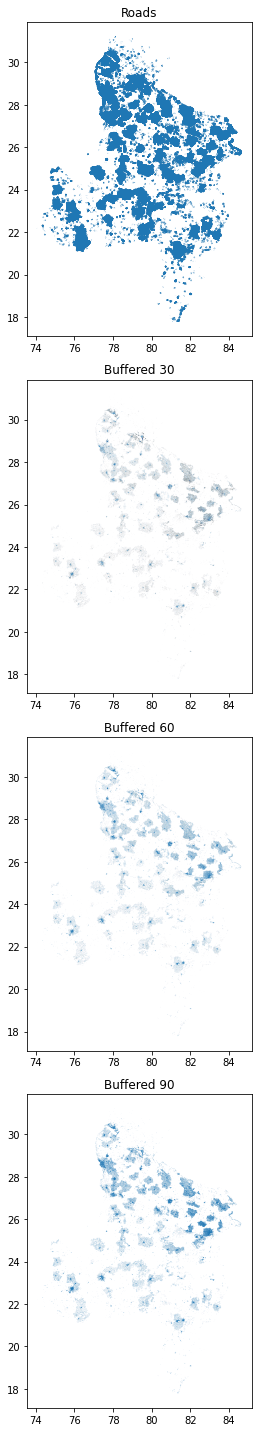

In [ ]:
# roads_cat1.plot()
# buffered_cat1_30.plot()
# buffered_cat1_60.plot()
# buffered_cat1_90.plot()

import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=4, figsize=(10, 20))

roads_cat1.plot(ax=axes[0])
axes[0].set_title('Roads')

buffered_cat1_30.plot(ax=axes[1])
axes[1].set_title('Buffered 30')

buffered_cat1_60.plot(ax=axes[2])
axes[2].set_title('Buffered 60')

buffered_cat1_90.plot(ax=axes[3])
axes[3].set_title('Buffered 90')

plt.tight_layout()
plt.show()


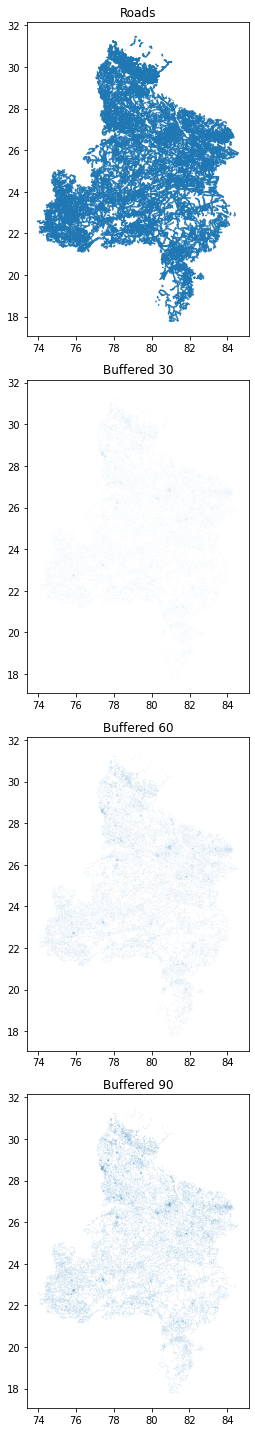

In [ ]:
# roads_cat2.plot()
# buffered_cat2_30.plot()
# buffered_cat2_60.plot()
# buffered_cat2_90.plot()

import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=4, figsize=(10, 20))

roads_cat2.plot(ax=axes[0])
axes[0].set_title('Roads')

buffered_cat2_30.plot(ax=axes[1])
axes[1].set_title('Buffered 30')

buffered_cat2_60.plot(ax=axes[2])
axes[2].set_title('Buffered 60')

buffered_cat2_90.plot(ax=axes[3])
axes[3].set_title('Buffered 90')

plt.tight_layout()
plt.show()


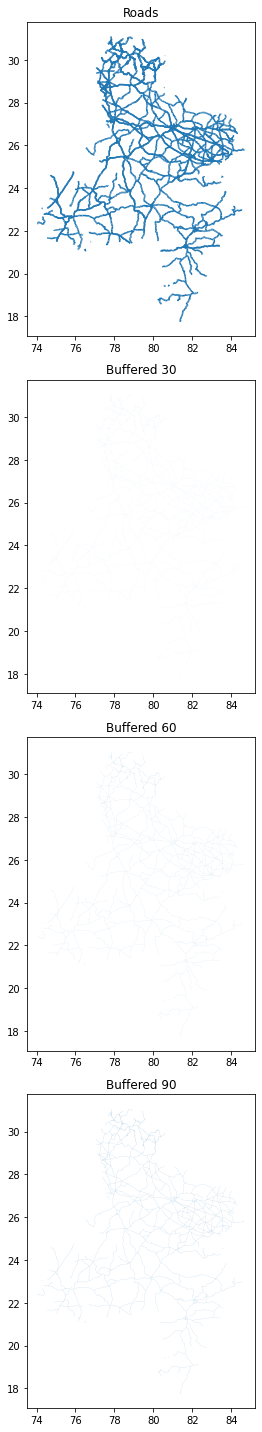

In [ ]:
# roads_cat3.plot()
# buffered_cat3_30.plot()
# buffered_cat3_60.plot()
# buffered_cat3_90.plot()

import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=4, figsize=(10, 20))

roads_cat3.plot(ax=axes[0])
axes[0].set_title('Roads')

buffered_cat3_30.plot(ax=axes[1])
axes[1].set_title('Buffered 30')

buffered_cat3_60.plot(ax=axes[2])
axes[2].set_title('Buffered 60')

buffered_cat3_90.plot(ax=axes[3])
axes[3].set_title('Buffered 90')

plt.tight_layout()
plt.show()


<Axes: >

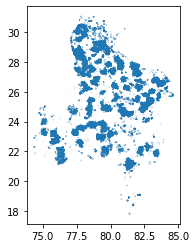

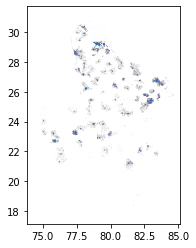

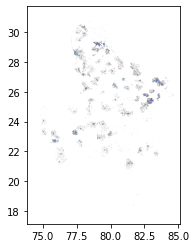

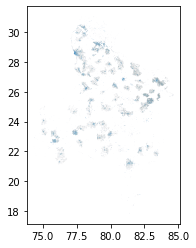

In [ ]:
roads_cat4.plot()
buffered_cat4_30.plot()
buffered_cat4_60.plot()
buffered_cat4_90.plot()

In [ ]:
def join_buildings(buffer_category, roads_category):
    buffered_category = {
        'cat1_30': buffered_cat1_30,
        'cat1_60': buffered_cat1_60,
        'cat1_90': buffered_cat1_90,
        'cat2_30': buffered_cat2_30,
        'cat2_60': buffered_cat2_60,
        'cat2_90': buffered_cat2_90,
        'cat3_30': buffered_cat3_30,
        'cat3_60': buffered_cat3_60,
        'cat3_90': buffered_cat3_90,
        'cat4_30': buffered_cat4_30,
        'cat4_60': buffered_cat4_60,
        'cat4_90': buffered_cat4_90,

    }.get(buffer_category)

    joined = buildings_gdf.sjoin(buffered_category, how='left')
    #joined = buildings_gdf.sjoin(buffered_category, how="left", predicate='intersects')
    joined.rename(columns={'index_right': 'index_roads'}, inplace=True)
    #joined.drop_duplicates(subset='id_left',inplace=True)
    if roads_category:
        joined['buffered_highway'] = \
            joined['buffered_highway'].apply(lambda x: 'not_residential' if pd.isnull(x) else x)
    else:
        joined['buffered_highway'] = \
            joined['buffered_highway'].apply(lambda x: 'residential' if pd.isnull(x) else x)

    joined.reset_index(inplace=True, drop=True)

    return joined

In [ ]:
buffer_categories = ['cat1_30', 'cat1_60', 'cat1_90','cat2_30','cat2_60','cat2_90',\
                    'cat3_30', 'cat3_60', 'cat3_90','cat4_30','cat4_60','cat4_90']
roads_category = 1                      # 1 is residential, 0 is ['primary', 'secondary','tertiary']
joined_buildings1 = join_buildings(buffer_categories[0],roads_category)
joined_buildings2 = join_buildings(buffer_categories[1],roads_category)
joined_buildings3 = join_buildings(buffer_categories[2],roads_category)
roads_category = 0
joined_buildings4 = join_buildings(buffer_categories[3],roads_category)
joined_buildings5 = join_buildings(buffer_categories[4],roads_category)
joined_buildings6 = join_buildings(buffer_categories[5],roads_category)
joined_buildings7 = join_buildings(buffer_categories[6],roads_category)
joined_buildings8 = join_buildings(buffer_categories[7],roads_category)
joined_buildings9 = join_buildings(buffer_categories[8],roads_category)
joined_buildings10 = join_buildings(buffer_categories[9],roads_category)
joined_buildings11 = join_buildings(buffer_categories[10],roads_category)
joined_buildings12 = join_buildings(buffer_categories[11],roads_category)

In [ ]:
print(joined_buildings1.shape)
print(joined_buildings2.shape)
print(joined_buildings3.shape)
print(joined_buildings4.shape)
print(joined_buildings5.shape)
print(joined_buildings6.shape)
print(joined_buildings7.shape)
print(joined_buildings8.shape)
print(joined_buildings9.shape)
print(joined_buildings10.shape)
print(joined_buildings11.shape)
print(joined_buildings12.shape)

(25411, 14)
(25411, 14)
(25411, 14)
(25411, 14)
(25411, 14)
(25411, 14)
(25411, 14)
(25411, 14)
(25411, 14)
(25411, 14)
(25411, 14)
(25411, 14)


In [ ]:
joined_buildings1.groupby('official_type').count()

,id_left,building,geometry,all_tag_keys,all_tags,index_landuse,landuse,land_building,index_official,OBJECTID,index_roads,id_right,buffered_highway
official_type,,,,,,,,,,,,,
NON_RES,25411,25411,25411,25411,25411,15616,25411,25411,25411,25411,23205,23205,25411


In [ ]:
joined_buildings1.groupby(['official_type','buffered_highway']).count()

id_left  building  geometry  all_tag_keys  \
official_type buffered_highway                                              
NON_RES       not_residential      2206      2206      2206          2206   
              residential         23205     23205     23205         23205   

                                all_tags  index_landuse  landuse  \
official_type buffered_highway                                     
NON_RES       not_residential       2206           1053     2206   
              residential          23205          14563    23205   

                                land_building  index_official  OBJECTID  \
official_type buffered_highway                                            
NON_RES       not_residential            2206            2206      2206   
              residential               23205           23205     23205   

                                index_roads  id_right  
official_type buffered_highway                         
NON_RES       not_residential             0         0  
              residential             23205     23205

In [ ]:
joined_buildings1[(joined_buildings1['land_building'] == 'commercial')\
               &(joined_buildings1['buffered_highway'] == 'residential')].shape

(0, 14)

In [ ]:
joined_buildings2.groupby(['official_type','buffered_highway']).count()

id_left  building  geometry  all_tag_keys  \
official_type buffered_highway                                              
NON_RES       not_residential       828       828       828           828   
              residential         24583     24583     24583         24583   

                                all_tags  index_landuse  landuse  \
official_type buffered_highway                                     
NON_RES       not_residential        828            289      828   
              residential          24583          15327    24583   

                                land_building  index_official  OBJECTID  \
official_type buffered_highway                                            
NON_RES       not_residential             828             828       828   
              residential               24583           24583     24583   

                                index_roads  id_right  
official_type buffered_highway                         
NON_RES       not_residential             0         0  
              residential             24583     24583

In [ ]:
joined_buildings3.groupby(['official_type','buffered_highway']).count()

id_left  building  geometry  all_tag_keys  \
official_type buffered_highway                                              
NON_RES       not_residential       448       448       448           448   
              residential         24963     24963     24963         24963   

                                all_tags  index_landuse  landuse  \
official_type buffered_highway                                     
NON_RES       not_residential        448            130      448   
              residential          24963          15486    24963   

                                land_building  index_official  OBJECTID  \
official_type buffered_highway                                            
NON_RES       not_residential             448             448       448   
              residential               24963           24963     24963   

                                index_roads  id_right  
official_type buffered_highway                         
NON_RES       not_residential             0         0  
              residential             24963     24963

In [ ]:
joined_buildings4.groupby(['official_type','buffered_highway']).count()

id_left  building  geometry  all_tag_keys  \
official_type buffered_highway                                              
NON_RES       non_res_road         2243      2243      2243          2243   
              residential         23168     23168     23168         23168   

                                all_tags  index_landuse  landuse  \
official_type buffered_highway                                     
NON_RES       non_res_road          2243           1458     2243   
              residential          23168          14158    23168   

                                land_building  index_official  OBJECTID  \
official_type buffered_highway                                            
NON_RES       non_res_road               2243            2243      2243   
              residential               23168           23168     23168   

                                index_roads  id_right  
official_type buffered_highway                         
NON_RES       non_res_road             2243      2243  
              residential                 0         0

In [ ]:
joined_buildings5.groupby(['official_type','buffered_highway']).count()

id_left  building  geometry  all_tag_keys  \
official_type buffered_highway                                              
NON_RES       non_res_road         6565      6565      6565          6565   
              residential         18846     18846     18846         18846   

                                all_tags  index_landuse  landuse  \
official_type buffered_highway                                     
NON_RES       non_res_road          6565           4220     6565   
              residential          18846          11396    18846   

                                land_building  index_official  OBJECTID  \
official_type buffered_highway                                            
NON_RES       non_res_road               6565            6565      6565   
              residential               18846           18846     18846   

                                index_roads  id_right  
official_type buffered_highway                         
NON_RES       non_res_road             6565      6565  
              residential                 0         0

In [ ]:
joined_buildings6.groupby(['official_type','buffered_highway']).count()

id_left  building  geometry  all_tag_keys  \
official_type buffered_highway                                              
NON_RES       non_res_road        11920     11920     11920         11920   
              residential         13491     13491     13491         13491   

                                all_tags  index_landuse  landuse  \
official_type buffered_highway                                     
NON_RES       non_res_road         11920           7761    11920   
              residential          13491           7855    13491   

                                land_building  index_official  OBJECTID  \
official_type buffered_highway                                            
NON_RES       non_res_road              11920           11920     11920   
              residential               13491           13491     13491   

                                index_roads  id_right  
official_type buffered_highway                         
NON_RES       non_res_road            11920     11920  
              residential                 0         0

In [ ]:
joined_buildings7.groupby(['official_type','buffered_highway']).count()

id_left  building  geometry  all_tag_keys  \
official_type buffered_highway                                              
NON_RES       residential         25397     25397     25397         25397   
              roads_cat3             14        14        14            14   

                                all_tags  index_landuse  landuse  \
official_type buffered_highway                                     
NON_RES       residential          25397          15616    25397   
              roads_cat3              14              0       14   

                                land_building  index_official  OBJECTID  \
official_type buffered_highway                                            
NON_RES       residential               25397           25397     25397   
              roads_cat3                   14              14        14   

                                index_roads  id_right  
official_type buffered_highway                         
NON_RES       residential                 0         0  
              roads_cat3                 14        14

In [ ]:
joined_buildings8.groupby(['official_type','buffered_highway']).count()

id_left  building  geometry  all_tag_keys  \
official_type buffered_highway                                              
NON_RES       residential         25345     25345     25345         25345   
              roads_cat3             66        66        66            66   

                                all_tags  index_landuse  landuse  \
official_type buffered_highway                                     
NON_RES       residential          25345          15606    25345   
              roads_cat3              66             10       66   

                                land_building  index_official  OBJECTID  \
official_type buffered_highway                                            
NON_RES       residential               25345           25345     25345   
              roads_cat3                   66              66        66   

                                index_roads  id_right  
official_type buffered_highway                         
NON_RES       residential                 0         0  
              roads_cat3                 66        66

In [ ]:
joined_buildings9.groupby(['official_type','buffered_highway']).count()

id_left  building  geometry  all_tag_keys  \
official_type buffered_highway                                              
NON_RES       residential         25283     25283     25283         25283   
              roads_cat3            128       128       128           128   

                                all_tags  index_landuse  landuse  \
official_type buffered_highway                                     
NON_RES       residential          25283          15592    25283   
              roads_cat3             128             24      128   

                                land_building  index_official  OBJECTID  \
official_type buffered_highway                                            
NON_RES       residential               25283           25283     25283   
              roads_cat3                  128             128       128   

                                index_roads  id_right  
official_type buffered_highway                         
NON_RES       residential                 0         0  
              roads_cat3                128       128

In [ ]:
len(areahandler.osm_data)

3024424

In [ ]:
keys_list = []
for sublist in areahandler.osm_data:
    keys_list.append(sublist[3])

In [ ]:
keys_list_flat = [val for sublist in keys_list for val in sublist]

In [ ]:
unique_keys = sorted(list(set(keys_list_flat)))

In [ ]:
unique_keys

['3dr:type',
 'FIXME',
 'POI',
 'abandoned',
 'abandoned:building',
 'abandoned:man_made',
 'abandoned:railway',
 'access',
 'addr:block',
 'addr:block:en',
 'addr:block_number',
 'addr:city',
 'addr:city:pa',
 'addr:city:ur',
 'addr:country',
 'addr:district',
 'addr:full',
 'addr:hamlet',
 'addr:housename',
 'addr:housenumber',
 'addr:interpolation',
 'addr:locality',
 'addr:neighbourhood',
 'addr:place',
 'addr:postcode',
 'addr:state',
 'addr:street',
 'addr:street:name',
 'addr:street:ur',
 'addr:subdistrict',
 'addr:suburb',
 'addr:unit',
 'addr:village',
 'address',
 'aerialway',
 'aeroway',
 'air_conditioning',
 'alt_name',
 'alt_name:en',
 'alt_name:es',
 'alt_name:ur',
 'amenity',
 'amenity_1',
 'animal_breeding',
 'animal_shelter',
 'architect',
 'area',
 'area:highway',
 'artwork_type',
 'atm',
 'barrier',
 'basilica',
 'bench',
 'bicycle_parking',
 'bin',
 'branch',
 'brand',
 'brand:en',
 'brand:es',
 'brand:hi',
 'brand:kn',
 'brand:ks',
 'brand:pa',
 'brand:pnb',
 'bran

In [ ]:
key_freq = []
for key in unique_keys:
    key_freq.append(keys_list_flat.count(key))


In [ ]:
len(key_freq)

399

In [ ]:
keys_tuples = list(zip(unique_keys, key_freq))
keys_freq_df = pd.DataFrame(keys_tuples, columns = ['Key', 'Freq'])

In [ ]:
keys_freq_df.sort_values(by=['Freq'], inplace=True, ascending=False)

In [ ]:
keys_freq_df.reset_index(inplace=True, drop=True)

In [ ]:
keys_freq_df.head()

,Key,Freq
0,building,3024424
1,source,8650
2,name,6702
3,layer,5283
4,building:levels,2825


In [ ]:
keys_freq_df.sort_values(by=['Key'], inplace=False, ascending=True).head(20)

,Key,Freq
293,3dr:type,1
140,FIXME,8
239,POI,2
202,abandoned,3
174,abandoned:building,4
323,abandoned:man_made,1
167,abandoned:railway,4
96,access,20
82,addr:block,26
324,addr:block:en,1


In [ ]:
keys_freq_df.head(21)

,Key,Freq
0,building,3024424
1,source,8650
2,name,6702
3,layer,5283
4,building:levels,2825
5,amenity,2149
6,addr:housenumber,2039
7,addr:city,1906
8,addr:postcode,1754
9,addr:street,1306


In [ ]:
selected_tags = ['source','addr:street','name','building:levels',\
                'roof:shape','amenity','brand','website','shop']
num_keys = len(selected_tags)+2

In [ ]:
len(selected_tags)

9

In [ ]:
def preprocess_data(input_data, value_tags, selected_tags):
    col_pos = 2
    for tag_key in selected_tags:
        col_name = tag_key
        input_data.insert(col_pos,col_name,0)
        input_data[col_name] = input_data.apply(lambda x: 1 if tag_key in list(x['all_tag_keys']) \
            else 0, axis=1)

    for tag_key in value_tags:
        input_data[tag_key] = input_data.apply(lambda x: x['all_tags'].get(tag_key) \
            if tag_key in list(x['all_tag_keys']) else 0, axis=1)

    # fix anomalies in FFX County data
    # Block to be tested.........................
    input_data.drop(input_data[(input_data['building:levels'] == 'K-6')].index, inplace=True)
    input_data.loc[(input_data['building:levels'] == '-1,1,2,3'),'building:levels']=4

    input_data.drop(columns=['all_tag_keys', 'all_tags'], inplace=True)

    input_data['official_type'] = \
    input_data['official_type'].apply(lambda x: 1 if x == 'RES' else 0)

    return input_data

In [ ]:
def add_buffers(input_data,col_names, buffers_list):
    for num in range(0, len(col_names)):
        input_data.insert(num+2,col_names[num],buffers_list[num])
        input_data[col_names[num]] = input_data[col_names[num]].apply(lambda x: 1 if x == 'residential' else 0)

    return input_data

In [ ]:
#num_buffers = 6
#buffer_loc = 0
#value_tags = ['roof:shape','building:levels']
#col_names = ['buffer_cat1_30','buffer_cat1_60','buffer_cat1_90',\
#            'buffer_cat2_30','buffer_cat2_60','buffer_cat2_90']
#buffers_list = [joined_buildings1['buffered_highway'],joined_buildings2['buffered_highway'],\
#                joined_buildings3['buffered_highway'],joined_buildings4['buffered_highway'],\
#                joined_buildings5['buffered_highway'],joined_buildings6['buffered_highway']]

num_buffers = 12
buffer_loc = 0
value_tags = ['roof:shape','building:levels']
col_names = ['buffer_cat1_30','buffer_cat1_60','buffer_cat1_90',\
            'buffer_cat2_30','buffer_cat2_60','buffer_cat2_90',\
            'buffer_cat3_30','buffer_cat3_60','buffer_cat3_90',\
            'buffer_cat4_30','buffer_cat4_60','buffer_cat4_90']
buffers_list = [joined_buildings1['buffered_highway'],joined_buildings2['buffered_highway'],\
                joined_buildings3['buffered_highway'],joined_buildings4['buffered_highway'],\
                joined_buildings5['buffered_highway'],joined_buildings6['buffered_highway'],\
                joined_buildings7['buffered_highway'],joined_buildings8['buffered_highway'],\
                joined_buildings9['buffered_highway'],joined_buildings10['buffered_highway'],\
                joined_buildings11['buffered_highway'],joined_buildings12['buffered_highway']]
backup_data = joined_buildings1.copy()
#input_data = input_data[['geometry','official_type','land_building','all_tag_keys','all_tags']]
#input_data = input_data[['geometry','official_type','building','landuse','all_tag_keys','all_tags']]
#input_data = input_data[['geometry','official_type','building','landuse',\
#                        'all_tag_keys','all_tags','id_left']]
#input_data = input_data[['geometry','official_type','building','landuse','amenity_key','parking_area',\
#                        'all_tag_keys','all_tags']]
backup_data = backup_data[['geometry','official_type','building','landuse','land_building',\
                        'all_tag_keys','all_tags','id_left']]
backup_data.insert(len(backup_data.columns), 'area',backup_data['geometry'].to_crs(epsg=32610).area)
backup_data = preprocess_data(backup_data,value_tags,selected_tags)

backup_data = add_buffers(backup_data,col_names[buffer_loc:buffer_loc+num_buffers],\
                         buffers_list[buffer_loc:buffer_loc+num_buffers])

In [ ]:
len(areahandler.amenity_data)

5970

In [ ]:
# transform the list of roads into a pandas DataFrame
amenity_colnames = ['amenity_key', 'geometry']
amenity_df = pd.DataFrame(areahandler.amenity_data, columns=amenity_colnames)

In [ ]:
amenity_df.head()

,amenity_key,geometry
0,parking,"POLYGON ((83.1438 25.2834721, 83.1441801 25.28..."
1,school,"POLYGON ((83.121865 25.2822977, 83.1219508 25...."
2,school,"POLYGON ((83.1067978 25.2772202, 83.1083764 25..."
3,school,"POLYGON ((83.1043087 25.27729, 83.1056991 25.2..."
4,school,"POLYGON ((83.0638134 25.2838821, 83.0646855 25..."


In [ ]:
amenity_df.shape

(5970, 2)

In [ ]:
amenity_categories = amenity_df.groupby(['amenity_key'])['geometry'].count().reset_index(name="count")

In [ ]:
amenity_categories.tail(50)

,amenity_key,count
35,fuel,265
36,grave_yard,17
37,healthpost,1
38,hookah_lounge,1
39,hospital,294
40,ice_cream,1
41,industrial,1
42,internet_cafe,1
43,kindergarten,15
44,library,28


In [ ]:
parking_df = amenity_df[(amenity_df['amenity_key'] == 'parking') | (amenity_df['amenity_key'] == 'parking_space')]

In [ ]:
parking_df = parking_df.assign(amenity_key='parking')

In [ ]:
parking_df.reset_index(inplace=True, drop=True)

In [ ]:
parking_df.shape

(543, 2)

In [ ]:
parking_gdf = geopandas.GeoDataFrame(parking_df.copy(),crs="EPSG:4326",geometry='geometry')

In [ ]:
parking_gdf.insert(len(parking_gdf.columns), 'parking_area',parking_gdf['geometry'].to_crs(epsg=32610).area)

In [ ]:
parking_gdf.head()

,amenity_key,geometry,parking_area
0,parking,"POLYGON ((83.14380 25.28347, 83.14418 25.28347...",1953.788708
1,parking,"POLYGON ((82.87341 25.42310, 82.87463 25.42239...",12751.947148
2,parking,"POLYGON ((78.05273 27.16549, 78.05278 27.16545...",8676.175148
3,parking,"POLYGON ((75.80836 22.72909, 75.80877 22.72894...",13381.167222
4,parking,"POLYGON ((77.34047 28.58649, 77.34129 28.58564...",1379.083812


In [ ]:
parking_gdf.shape

(543, 3)

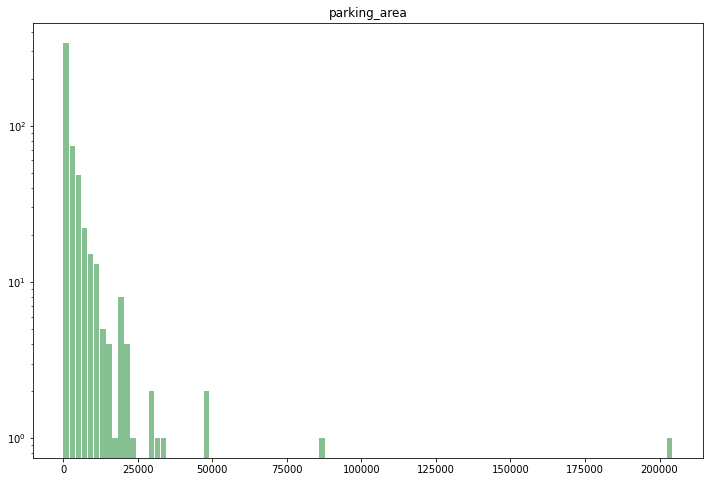

In [ ]:
hist = parking_gdf.hist(bins=100, grid=False, figsize=(12,8), color='#86bf91', zorder=2, rwidth=0.9)
plt.yscale('log')

In [ ]:
breaks = jenkspy.jenks_breaks(parking_gdf['parking_area'], n_classes=3)
print(breaks)

[41.46187516406551, 13381.167222416192, 87500.64669802594, 204344.19492878517]


In [ ]:
bins_list = ['bin1','bin2','bin3']
parking_gdf['cut_jenks'] = pd.cut(parking_gdf['parking_area'],
                                bins=breaks,
                                labels=bins_list,
                                include_lowest=True)

In [ ]:
parking_gdf.head()

,amenity_key,geometry,parking_area,cut_jenks
0,parking,"POLYGON ((83.14380 25.28347, 83.14418 25.28347...",1953.788708,bin1
1,parking,"POLYGON ((82.87341 25.42310, 82.87463 25.42239...",12751.947148,bin1
2,parking,"POLYGON ((78.05273 27.16549, 78.05278 27.16545...",8676.175148,bin1
3,parking,"POLYGON ((75.80836 22.72909, 75.80877 22.72894...",13381.167222,bin1
4,parking,"POLYGON ((77.34047 28.58649, 77.34129 28.58564...",1379.083812,bin1


In [ ]:
for bin in bins_list:
    parking_gdf.insert(len(parking_gdf.columns),bin,0)
    parking_gdf[bin] = parking_gdf.apply(lambda x: 1 if x['cut_jenks'] == bin\
                                     else 0, axis=1)

In [ ]:
parking_gdf.head()

,amenity_key,geometry,parking_area,cut_jenks,bin1,bin2,bin3
0,parking,"POLYGON ((83.14380 25.28347, 83.14418 25.28347...",1953.788708,bin1,1,0,0
1,parking,"POLYGON ((82.87341 25.42310, 82.87463 25.42239...",12751.947148,bin1,1,0,0
2,parking,"POLYGON ((78.05273 27.16549, 78.05278 27.16545...",8676.175148,bin1,1,0,0
3,parking,"POLYGON ((75.80836 22.72909, 75.80877 22.72894...",13381.167222,bin1,1,0,0
4,parking,"POLYGON ((77.34047 28.58649, 77.34129 28.58564...",1379.083812,bin1,1,0,0


In [ ]:
backup_data.columns

Index(['geometry', 'official_type', 'buffer_cat1_30', 'buffer_cat1_60',
       'buffer_cat1_90', 'buffer_cat2_30', 'buffer_cat2_60', 'buffer_cat2_90',
       'buffer_cat3_30', 'buffer_cat3_60', 'buffer_cat3_90', 'buffer_cat4_30',
       'buffer_cat4_60', 'buffer_cat4_90', 'shop', 'website', 'brand',
       'amenity', 'roof:shape', 'building:levels', 'name', 'addr:street',
       'source', 'building', 'landuse', 'land_building', 'id_left', 'area'],
      dtype='object')

In [ ]:
radius_list = [30,60,90]
counter = 1
for bin in bins_list:
    for radius in radius_list:
        parking_buffer = parking_gdf.copy()
        parking_buffer = parking_buffer[['geometry',bin]]
        col_name = 'parking_cat'+str(counter)
        counter += 1
        parking_buffer.rename(columns={bin: col_name}, inplace=True)
        parking_buffer['geometry'] = parking_buffer['geometry'].to_crs(epsg=32610).buffer(radius)
        parking_buffer.to_crs(epsg=4326, inplace=True)
        buildings_parking = backup_data.sjoin(parking_buffer, how="left", predicate='intersects')
        buildings_parking[col_name] = buildings_parking[col_name].fillna(0)
        buildings_parking.drop_duplicates(subset='id_left',inplace=True)
        buildings_parking.reset_index(inplace=True, drop=True)
        backup_data.insert(len(backup_data.columns),col_name,list(buildings_parking[col_name]))

In [ ]:
backup_data.drop(columns=['id_left'], inplace=True)

In [ ]:
backup_data.shape

(25411, 36)

In [ ]:
backup_data.head()

,geometry,official_type,buffer_cat1_30,buffer_cat1_60,buffer_cat1_90,buffer_cat2_30,buffer_cat2_60,buffer_cat2_90,buffer_cat3_30,buffer_cat3_60,...,area,parking_cat1,parking_cat2,parking_cat3,parking_cat4,parking_cat5,parking_cat6,parking_cat7,parking_cat8,parking_cat9
0,"POLYGON ((77.41015 23.27884, 77.41057 23.27876...",0,0,0,1,1,1,0,1,1,...,1388.855014,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,"POLYGON ((77.40992 23.28095, 77.41010 23.28078...",0,0,0,1,1,1,0,1,1,...,479.957186,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,"POLYGON ((77.40989 23.28106, 77.40996 23.28100...",0,0,0,1,1,1,0,1,1,...,111.472112,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,"POLYGON ((77.40663 23.27965, 77.40700 23.27960...",0,0,0,1,0,0,0,1,1,...,636.629942,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,"POLYGON ((77.43047 23.23162, 77.43056 23.23118...",0,0,1,1,1,0,0,1,1,...,2955.429585,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# content_Bhopal = os.listdir("/DATA2/dse313/group15/Bhopal/")

if "Bhopal_Backup_Data" not in os.listdir("/DATA2/dse313/group15/Bhopal/"):
    os.mkdir("/DATA2/dse313/group15/Bhopal/Bhopal_Backup_Data/")

backup_data.to_pickle("/DATA2/dse313/group15/Bhopal/Bhopal_Backup_Data/Bhopal.pkl")

In [ ]:
backup_data = pd.read_pickle("/DATA2/dse313/group15/Bhopal/Bhopal_Backup_Data/Bhopal.pkl")

In [ ]:
input_data = backup_data.copy()

In [ ]:
input_data.columns

Index(['geometry', 'official_type', 'buffer_cat1_30', 'buffer_cat1_60',
       'buffer_cat1_90', 'buffer_cat2_30', 'buffer_cat2_60', 'buffer_cat2_90',
       'buffer_cat3_30', 'buffer_cat3_60', 'buffer_cat3_90', 'buffer_cat4_30',
       'buffer_cat4_60', 'buffer_cat4_90', 'shop', 'website', 'brand',
       'amenity', 'roof:shape', 'building:levels', 'name', 'addr:street',
       'source', 'building', 'landuse', 'land_building', 'area',
       'parking_cat1', 'parking_cat2', 'parking_cat3', 'parking_cat4',
       'parking_cat5', 'parking_cat6', 'parking_cat7', 'parking_cat8',
       'parking_cat9'],
      dtype='object')

In [ ]:
#input_data.drop(columns=['buffer_cat1_30', 'buffer_cat1_60',\
#                        'buffer_cat1_90', 'buffer_cat2_30', 'buffer_cat2_60', 'buffer_cat2_90',\
#                        'buffer_cat3_30', 'buffer_cat3_60', 'buffer_cat3_90', 'buffer_cat4_30',\
#                        'buffer_cat4_60', 'buffer_cat4_90',\
#                        \
#                        'land_building',\
#                        'parking_cat1', 'parking_cat2', 'parking_cat3', 'parking_cat4',\
#                        'parking_cat5', 'parking_cat6', 'parking_cat7', 'parking_cat8',\
#                        'parking_cat9'], inplace=True)

In [ ]:
input_data.drop(columns=['land_building', 'roof:shape'], inplace=True)

In [ ]:
input_data.columns

Index(['geometry', 'official_type', 'buffer_cat1_30', 'buffer_cat1_60',
       'buffer_cat1_90', 'buffer_cat2_30', 'buffer_cat2_60', 'buffer_cat2_90',
       'buffer_cat3_30', 'buffer_cat3_60', 'buffer_cat3_90', 'buffer_cat4_30',
       'buffer_cat4_60', 'buffer_cat4_90', 'shop', 'website', 'brand',
       'amenity', 'building:levels', 'name', 'addr:street', 'source',
       'building', 'landuse', 'area', 'parking_cat1', 'parking_cat2',
       'parking_cat3', 'parking_cat4', 'parking_cat5', 'parking_cat6',
       'parking_cat7', 'parking_cat8', 'parking_cat9'],
      dtype='object')

In [ ]:
input_data.shape

(25411, 34)

In [ ]:
input_data.groupby('landuse').count().sort_values(by=['geometry'], inplace=False, ascending=False).head(50)

,geometry,official_type,buffer_cat1_30,buffer_cat1_60,buffer_cat1_90,buffer_cat2_30,buffer_cat2_60,buffer_cat2_90,buffer_cat3_30,buffer_cat3_60,...,area,parking_cat1,parking_cat2,parking_cat3,parking_cat4,parking_cat5,parking_cat6,parking_cat7,parking_cat8,parking_cat9
landuse,,,,,,,,,,,,,,,,,,,,,
residential,15327,15327,15327,15327,15327,15327,15327,15327,15327,15327,...,15327,15327,15327,15327,15327,15327,15327,15327,15327,15327
no_landuse,9795,9795,9795,9795,9795,9795,9795,9795,9795,9795,...,9795,9795,9795,9795,9795,9795,9795,9795,9795,9795
non_res,218,218,218,218,218,218,218,218,218,218,...,218,218,218,218,218,218,218,218,218,218
military,61,61,61,61,61,61,61,61,61,61,...,61,61,61,61,61,61,61,61,61,61
farmland,9,9,9,9,9,9,9,9,9,9,...,9,9,9,9,9,9,9,9,9,9
recreation_ground,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [ ]:
input_data.groupby('building').count().sort_values(by=['geometry'], inplace=False, ascending=False).head(50)

,geometry,official_type,buffer_cat1_30,buffer_cat1_60,buffer_cat1_90,buffer_cat2_30,buffer_cat2_60,buffer_cat2_90,buffer_cat3_30,buffer_cat3_60,...,area,parking_cat1,parking_cat2,parking_cat3,parking_cat4,parking_cat5,parking_cat6,parking_cat7,parking_cat8,parking_cat9
building,,,,,,,,,,,,,,,,,,,,,
yes,25369,25369,25369,25369,25369,25369,25369,25369,25369,25369,...,25369,25369,25369,25369,25369,25369,25369,25369,25369,25369
house,14,14,14,14,14,14,14,14,14,14,...,14,14,14,14,14,14,14,14,14,14
storage_tank,6,6,6,6,6,6,6,6,6,6,...,6,6,6,6,6,6,6,6,6,6
apartments,5,5,5,5,5,5,5,5,5,5,...,5,5,5,5,5,5,5,5,5,5
industrial,5,5,5,5,5,5,5,5,5,5,...,5,5,5,5,5,5,5,5,5,5
residential,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
school,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
transportation,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
university,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2


In [ ]:
input_data['building'].unique()

array(['industrial', 'yes', 'house', 'roof', 'storage_tank', 'hospital',
       'school', 'commercial', 'residential', 'apartments', 'shed',
       'university', 'transportation'], dtype=object)

In [ ]:
common_buildings = np.array(['apartments', 'church', 'civic', 'commercial', 'construction',
       'detached', 'dormitory', 'garage', 'garages', 'greenhouse',
       'hospital', 'hotel', 'house', 'industrial', 'kindergarten',
       'office', 'parking', 'public', 'residential', 'retail', 'roof',
       'school', 'semidetached_house', 'service', 'shed',
       'static_caravan', 'terrace', 'warehouse', 'yes'], dtype=object)

In [ ]:
unique_buildings = np.setxor1d(input_data['building'].unique(), common_buildings).tolist()

In [ ]:
unique_buildings

['church',
 'civic',
 'construction',
 'detached',
 'dormitory',
 'garage',
 'garages',
 'greenhouse',
 'hotel',
 'kindergarten',
 'office',
 'parking',
 'public',
 'retail',
 'semidetached_house',
 'service',
 'static_caravan',
 'storage_tank',
 'terrace',
 'transportation',
 'university',
 'warehouse']

In [ ]:
len(unique_buildings)

22

In [ ]:
input_data[input_data['building'].isin(unique_buildings)].shape

(10, 34)

In [ ]:
input_data['building'] = input_data['building'].apply(\
                                lambda x: 'misc_buildings' if x in(unique_buildings)
                                                else x)

In [ ]:
input_data[input_data['building'].isin(unique_buildings)].shape

(0, 34)

In [ ]:
input_data.shape

(25411, 34)

In [ ]:
input_data.groupby('building').count().sort_values(by=['geometry'], inplace=False, ascending=False).head(50)

,geometry,official_type,buffer_cat1_30,buffer_cat1_60,buffer_cat1_90,buffer_cat2_30,buffer_cat2_60,buffer_cat2_90,buffer_cat3_30,buffer_cat3_60,...,area,parking_cat1,parking_cat2,parking_cat3,parking_cat4,parking_cat5,parking_cat6,parking_cat7,parking_cat8,parking_cat9
building,,,,,,,,,,,,,,,,,,,,,
yes,25369,25369,25369,25369,25369,25369,25369,25369,25369,25369,...,25369,25369,25369,25369,25369,25369,25369,25369,25369,25369
house,14,14,14,14,14,14,14,14,14,14,...,14,14,14,14,14,14,14,14,14,14
misc_buildings,10,10,10,10,10,10,10,10,10,10,...,10,10,10,10,10,10,10,10,10,10
apartments,5,5,5,5,5,5,5,5,5,5,...,5,5,5,5,5,5,5,5,5,5
industrial,5,5,5,5,5,5,5,5,5,5,...,5,5,5,5,5,5,5,5,5,5
residential,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
school,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
commercial,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
hospital,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [ ]:
common_landuse = np.array(['non_res', 'no_landuse', 'residential', 'construction',
       'forest', 'recreation_ground', 'cemetery', 'farmyard'], dtype=object)

In [ ]:
unique_landuse = np.setxor1d(input_data['landuse'].unique(), common_landuse).tolist()

In [ ]:
unique_landuse

['cemetery', 'construction', 'farmland', 'farmyard', 'forest', 'military']

In [ ]:
input_data[input_data['landuse'].isin(unique_landuse)].shape

(70, 34)

In [ ]:
input_data['landuse'] = input_data['landuse'].apply(\
                                lambda x: 'misc_landuse' if x in(unique_landuse)
                                                else x)

In [ ]:
input_data[input_data['landuse'].isin(unique_landuse)].shape

(0, 34)

In [ ]:
input_data.groupby('landuse').count().sort_values(by=['geometry'], inplace=False, ascending=False).head(50)

,geometry,official_type,buffer_cat1_30,buffer_cat1_60,buffer_cat1_90,buffer_cat2_30,buffer_cat2_60,buffer_cat2_90,buffer_cat3_30,buffer_cat3_60,...,area,parking_cat1,parking_cat2,parking_cat3,parking_cat4,parking_cat5,parking_cat6,parking_cat7,parking_cat8,parking_cat9
landuse,,,,,,,,,,,,,,,,,,,,,
residential,15327,15327,15327,15327,15327,15327,15327,15327,15327,15327,...,15327,15327,15327,15327,15327,15327,15327,15327,15327,15327
no_landuse,9795,9795,9795,9795,9795,9795,9795,9795,9795,9795,...,9795,9795,9795,9795,9795,9795,9795,9795,9795,9795
non_res,218,218,218,218,218,218,218,218,218,218,...,218,218,218,218,218,218,218,218,218,218
misc_landuse,70,70,70,70,70,70,70,70,70,70,...,70,70,70,70,70,70,70,70,70,70
recreation_ground,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [ ]:
input_data['landuse'].replace(['residential','non_res','forest','cemetery','recreation_ground',\
                                'construction','farmyard'],['residential_landuse','non_res_landuse',\
                                'forest_landuse','cemetery_landuse','recreation_ground_landuse',\
                                'construction_landuse','farmyard_landuse'], inplace=True)

In [ ]:
input_data.groupby('landuse').count().sort_values(by=['geometry'], inplace=False, ascending=False).head(50)

,geometry,official_type,buffer_cat1_30,buffer_cat1_60,buffer_cat1_90,buffer_cat2_30,buffer_cat2_60,buffer_cat2_90,buffer_cat3_30,buffer_cat3_60,...,area,parking_cat1,parking_cat2,parking_cat3,parking_cat4,parking_cat5,parking_cat6,parking_cat7,parking_cat8,parking_cat9
landuse,,,,,,,,,,,,,,,,,,,,,
residential_landuse,15327,15327,15327,15327,15327,15327,15327,15327,15327,15327,...,15327,15327,15327,15327,15327,15327,15327,15327,15327,15327
no_landuse,9795,9795,9795,9795,9795,9795,9795,9795,9795,9795,...,9795,9795,9795,9795,9795,9795,9795,9795,9795,9795
non_res_landuse,218,218,218,218,218,218,218,218,218,218,...,218,218,218,218,218,218,218,218,218,218
misc_landuse,70,70,70,70,70,70,70,70,70,70,...,70,70,70,70,70,70,70,70,70,70
recreation_ground_landuse,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [ ]:
input_data.shape

(25411, 34)

In [ ]:
input_data.columns

Index(['geometry', 'official_type', 'buffer_cat1_30', 'buffer_cat1_60',
       'buffer_cat1_90', 'buffer_cat2_30', 'buffer_cat2_60', 'buffer_cat2_90',
       'buffer_cat3_30', 'buffer_cat3_60', 'buffer_cat3_90', 'buffer_cat4_30',
       'buffer_cat4_60', 'buffer_cat4_90', 'shop', 'website', 'brand',
       'amenity', 'building:levels', 'name', 'addr:street', 'source',
       'building', 'landuse', 'area', 'parking_cat1', 'parking_cat2',
       'parking_cat3', 'parking_cat4', 'parking_cat5', 'parking_cat6',
       'parking_cat7', 'parking_cat8', 'parking_cat9'],
      dtype='object')

In [ ]:
Bhopal_baseline = input_data.copy()

In [ ]:
Bhopal_baseline.columns

Index(['geometry', 'official_type', 'buffer_cat1_30', 'buffer_cat1_60',
       'buffer_cat1_90', 'buffer_cat2_30', 'buffer_cat2_60', 'buffer_cat2_90',
       'buffer_cat3_30', 'buffer_cat3_60', 'buffer_cat3_90', 'buffer_cat4_30',
       'buffer_cat4_60', 'buffer_cat4_90', 'shop', 'website', 'brand',
       'amenity', 'building:levels', 'name', 'addr:street', 'source',
       'building', 'landuse', 'area', 'parking_cat1', 'parking_cat2',
       'parking_cat3', 'parking_cat4', 'parking_cat5', 'parking_cat6',
       'parking_cat7', 'parking_cat8', 'parking_cat9'],
      dtype='object')

In [ ]:
Bhopal_baseline = Bhopal_baseline[['geometry', 'official_type', 'building']]

In [ ]:
Bhopal_baseline.columns

Index(['geometry', 'official_type', 'building'], dtype='object')

In [ ]:
Bhopal_baseline.head()

,geometry,official_type,building
0,"POLYGON ((77.41015 23.27884, 77.41057 23.27876...",0,industrial
1,"POLYGON ((77.40992 23.28095, 77.41010 23.28078...",0,industrial
2,"POLYGON ((77.40989 23.28106, 77.40996 23.28100...",0,industrial
3,"POLYGON ((77.40663 23.27965, 77.40700 23.27960...",0,industrial
4,"POLYGON ((77.43047 23.23162, 77.43056 23.23118...",0,yes


In [ ]:
residential_list = ['residential','apartments','dormitory', 'house','semidetached_house']
Bhopal_baseline['building'] = Bhopal_baseline['building'].apply(\
                                lambda x: 'residential' if x in(residential_list)
                                                else x)

In [ ]:
non_residential_list = ['public','commercial','industrial', 'school','church','office',
                        'retail','hotel','warehouse','kindergarten','civic','hospital']
Bhopal_baseline['building'] = Bhopal_baseline['building'].apply(\
                                lambda x: 'non_residential' if x in(non_residential_list)
                                                else x)

In [ ]:
unknown_list = ['yes','detached','terrace', 'garage','roof','shed',
                'parking','garages','greenhouse','static_caravan','service','construction',
                'misc_buildings']
Bhopal_baseline['building'] = Bhopal_baseline['building'].apply(\
                                lambda x: 'unknown' if x in(unknown_list)
                                                else x)

In [ ]:
Bhopal_baseline.head()

,geometry,official_type,building
0,"POLYGON ((77.41015 23.27884, 77.41057 23.27876...",0,non_residential
1,"POLYGON ((77.40992 23.28095, 77.41010 23.28078...",0,non_residential
2,"POLYGON ((77.40989 23.28106, 77.40996 23.28100...",0,non_residential
3,"POLYGON ((77.40663 23.27965, 77.40700 23.27960...",0,non_residential
4,"POLYGON ((77.43047 23.23162, 77.43056 23.23118...",0,unknown


In [ ]:
Bhopal_baseline.groupby('building').count()

,geometry,official_type
building,,
non_residential,9,9
residential,21,21
unknown,25381,25381


In [ ]:
Bhopal_baseline.groupby(['official_type','building']).count()

geometry
official_type building                 
0             non_residential         9
              residential            21
              unknown             25381

In [ ]:
if "Bhopal_Baseline" not in os.listdir("/DATA2/dse313/group15/Bhopal/"):
    os.mkdir("/DATA2/dse313/group15/Bhopal/Bhopal_Baseline/")

Bhopal_baseline.to_file("/DATA2/dse313/group15/Bhopal/Bhopal_Baseline/Bhopal_Baseline.shp")

<ipython-input-190-a2cf5f5ec27f>:4: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  Bhopal_baseline.to_file("/DATA2/dse313/group15/Bhopal/Bhopal_Baseline/Bhopal_Baseline.shp")


In [ ]:
Bhopal_baseline.groupby('official_type').count()

,geometry,building
official_type,,
0,25411,25411


In [ ]:
#output_filtered.to_file("./Datasets/OSM/Geopandas_Output/filtered_output.shp")
#input_data.to_file("./Datasets/OSM/Geopandas_Output/input_data.shp")

In [ ]:
def nominal_transform(input_data, value_tags):
    ohe = preprocessing.OneHotEncoder(sparse = False)
    for tag in value_tags:
        ohe_results = ohe.fit_transform(input_data[[tag]])
        input_data.reset_index(inplace=True, drop=True)
        input_data = pd.concat([input_data, \
            pd.DataFrame(ohe_results, columns=ohe.categories_[0].tolist())], axis=1)
        input_data.drop(columns=[tag], inplace=True)

    return input_data

In [ ]:
# nominal transform

#value_tags = ['roof:shape','building','landuse']
#value_tags = ['roof:shape','land_building']
#value_tags = ['roof:shape','building']
value_tags = ['building','landuse']
nominal_data = input_data.copy()
#nominal_data['roof:shape'] = nominal_data['roof:shape'].astype(str)
nominal_data = nominal_transform(nominal_data, value_tags)
nominal_features = list(nominal_data.columns[2:])
nominal_features

/home/dse313/.local/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/dse313/.local/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


['buffer_cat1_30',
 'buffer_cat1_60',
 'buffer_cat1_90',
 'buffer_cat2_30',
 'buffer_cat2_60',
 'buffer_cat2_90',
 'buffer_cat3_30',
 'buffer_cat3_60',
 'buffer_cat3_90',
 'buffer_cat4_30',
 'buffer_cat4_60',
 'buffer_cat4_90',
 'shop',
 'website',
 'brand',
 'amenity',
 'building:levels',
 'name',
 'addr:street',
 'source',
 'area',
 'parking_cat1',
 'parking_cat2',
 'parking_cat3',
 'parking_cat4',
 'parking_cat5',
 'parking_cat6',
 'parking_cat7',
 'parking_cat8',
 'parking_cat9',
 'apartments',
 'commercial',
 'hospital',
 'house',
 'industrial',
 'misc_buildings',
 'residential',
 'roof',
 'school',
 'shed',
 'yes',
 'misc_landuse',
 'no_landuse',
 'non_res_landuse',
 'recreation_ground_landuse',
 'residential_landuse']

In [ ]:
nominal_data.columns

Index(['geometry', 'official_type', 'buffer_cat1_30', 'buffer_cat1_60',
       'buffer_cat1_90', 'buffer_cat2_30', 'buffer_cat2_60', 'buffer_cat2_90',
       'buffer_cat3_30', 'buffer_cat3_60', 'buffer_cat3_90', 'buffer_cat4_30',
       'buffer_cat4_60', 'buffer_cat4_90', 'shop', 'website', 'brand',
       'amenity', 'building:levels', 'name', 'addr:street', 'source', 'area',
       'parking_cat1', 'parking_cat2', 'parking_cat3', 'parking_cat4',
       'parking_cat5', 'parking_cat6', 'parking_cat7', 'parking_cat8',
       'parking_cat9', 'apartments', 'commercial', 'hospital', 'house',
       'industrial', 'misc_buildings', 'residential', 'roof', 'school', 'shed',
       'yes', 'misc_landuse', 'no_landuse', 'non_res_landuse',
       'recreation_ground_landuse', 'residential_landuse'],
      dtype='object')

In [ ]:
sorted(nominal_data.columns)

['addr:street',
 'amenity',
 'apartments',
 'area',
 'brand',
 'buffer_cat1_30',
 'buffer_cat1_60',
 'buffer_cat1_90',
 'buffer_cat2_30',
 'buffer_cat2_60',
 'buffer_cat2_90',
 'buffer_cat3_30',
 'buffer_cat3_60',
 'buffer_cat3_90',
 'buffer_cat4_30',
 'buffer_cat4_60',
 'buffer_cat4_90',
 'building:levels',
 'commercial',
 'geometry',
 'hospital',
 'house',
 'industrial',
 'misc_buildings',
 'misc_landuse',
 'name',
 'no_landuse',
 'non_res_landuse',
 'official_type',
 'parking_cat1',
 'parking_cat2',
 'parking_cat3',
 'parking_cat4',
 'parking_cat5',
 'parking_cat6',
 'parking_cat7',
 'parking_cat8',
 'parking_cat9',
 'recreation_ground_landuse',
 'residential',
 'residential_landuse',
 'roof',
 'school',
 'shed',
 'shop',
 'source',
 'website',
 'yes']

In [ ]:
nominal_data.shape

(25411, 48)

In [ ]:
nominal_data.head()

,geometry,official_type,buffer_cat1_30,buffer_cat1_60,buffer_cat1_90,buffer_cat2_30,buffer_cat2_60,buffer_cat2_90,buffer_cat3_30,buffer_cat3_60,...,residential,roof,school,shed,yes,misc_landuse,no_landuse,non_res_landuse,recreation_ground_landuse,residential_landuse
0,"POLYGON ((77.41015 23.27884, 77.41057 23.27876...",0,0,0,1,1,1,0,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,"POLYGON ((77.40992 23.28095, 77.41010 23.28078...",0,0,0,1,1,1,0,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,"POLYGON ((77.40989 23.28106, 77.40996 23.28100...",0,0,0,1,1,1,0,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,"POLYGON ((77.40663 23.27965, 77.40700 23.27960...",0,0,0,1,0,0,0,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,"POLYGON ((77.43047 23.23162, 77.43056 23.23118...",0,0,1,1,1,0,0,1,1,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


Confusion matrix:
[[5083]]


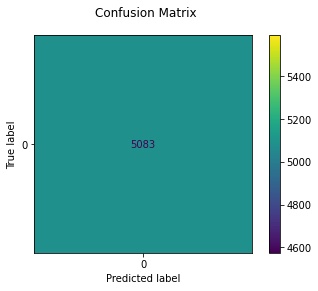

Classification report for classifier DecisionTreeClassifier(class_weight={0: 2.0, 1: 1.0},
                       min_impurity_decrease=0.0001, min_samples_split=20,
                       random_state=0):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5083

    accuracy                           1.00      5083
   macro avg       1.00      1.00      1.00      5083
weighted avg       1.00      1.00      1.00      5083




In [ ]:
# latest, building and landuse

X = nominal_data[nominal_features]
y = nominal_data["official_type"]
weights = {0:2.0, 1:1.0}

# Split data into 80% train and 20% test subsets
X_train, X_test, y_train, y_test = train_test_split(\
    X, y, test_size=0.2, shuffle=True)
dt_split = DecisionTreeClassifier(class_weight=weights,min_samples_split=20, \
                                random_state=0,min_impurity_decrease = 0.0001)

#dt_split = DecisionTreeClassifier(min_samples_split=20, random_state=0,min_impurity_decrease = 0.0001)

# Learn on the train subset
dt_split.fit(X_train, y_train)

# Predict the target on the test subset
predicted = dt_split.predict(X_test)

# 1 = RES; 0 = NON_RES

disp = metrics.ConfusionMatrixDisplay.from_predictions(y_test, predicted)
disp.figure_.suptitle("Confusion Matrix")
print(f"Confusion matrix:\n{disp.confusion_matrix}")

plt.show()

print(
    f"Classification report for classifier {dt_split}:\n"
    f"{metrics.classification_report(y_test, predicted)}\n"
)

Confusion matrix:
[[5083]]


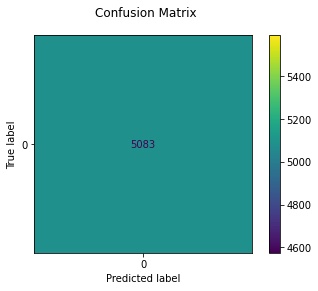

Classification report for classifier KNeighborsClassifier(n_neighbors=3):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5083

    accuracy                           1.00      5083
   macro avg       1.00      1.00      1.00      5083
weighted avg       1.00      1.00      1.00      5083




In [ ]:
## K-nearest neighbours

import sklearn
from sklearn.neighbors import KNeighborsClassifier

X = nominal_data[nominal_features]
y = nominal_data["official_type"]
weights = {0:2.0, 1:1.0}

# Split data into 80% train and 20% test subsets
X_train, X_test, y_train, y_test = train_test_split(\
    X, y, test_size=0.2, shuffle=True)

knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

y_pred_knn = knn.predict(X_test)

disp = metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred_knn)
disp.figure_.suptitle("Confusion Matrix")
print(f"Confusion matrix:\n{disp.confusion_matrix}")

plt.show()

print(
    f"Classification report for classifier {knn}:\n"
    f"{metrics.classification_report(y_test, y_pred_knn)}\n"
)

Confusion matrix:
[[5083]]


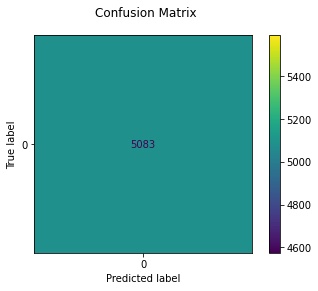

Classification report for classifier RandomForestClassifier(class_weight={0: 2.0, 1: 1.0},
                       min_impurity_decrease=0.0001, min_samples_split=20,
                       random_state=0):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5083

    accuracy                           1.00      5083
   macro avg       1.00      1.00      1.00      5083
weighted avg       1.00      1.00      1.00      5083




In [ ]:
## random Forest

from sklearn.ensemble import RandomForestClassifier

# Classifier
weights = {0:2.0, 1:1.0}
rf_clf = RandomForestClassifier(\
    n_estimators=100, random_state=0, min_samples_split=20, \
        min_impurity_decrease=0.0001, class_weight=weights)


rf_clf.fit(X_train, y_train)

# RF predictions
y_pred_rf = rf_clf.predict(X_test)

disp = metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf)
disp.figure_.suptitle("Confusion Matrix")
print(f"Confusion matrix:\n{disp.confusion_matrix}")

plt.show()

print(
    f"Classification report for classifier {rf_clf}:\n"
    f"{metrics.classification_report(y_test, y_pred_rf)}\n"
)

Confusion matrix:
[[5083]]


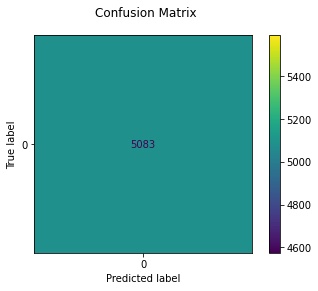

Classification report for classifier GaussianNB():
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5083

    accuracy                           1.00      5083
   macro avg       1.00      1.00      1.00      5083
weighted avg       1.00      1.00      1.00      5083




In [ ]:
# GaussianNB

from sklearn.naive_bayes import GaussianNB

# Classifoer
gnb = GaussianNB()

# training
gnb.fit(X_train, y_train)

# gnb predicions
y_pred_gnb = gnb.predict(X_test)

disp = metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred_gnb)
disp.figure_.suptitle("Confusion Matrix")
print(f"Confusion matrix:\n{disp.confusion_matrix}")

plt.show()

print(
    f"Classification report for classifier {gnb}:\n"
    f"{metrics.classification_report(y_test, y_pred_gnb)}\n"
)

In [ ]:
# # linear perceptron

# from sklearn.linear_model import Perceptron

# perceptron = Perceptron()
# perceptron.fit(X_train, y_train)

# y_pred_perceptron = perceptron.predict(X_test)

# disp = metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred_perceptron)
# disp.figure_.suptitle("Confusion Matrix")
# print(f"Confusion matrix:\n{disp.confusion_matrix}")

# plt.show()

# print(
#     f"Classification report for classifier {perceptron}:\n"
#     f"{metrics.classification_report(y_test, y_pred_perceptron)}\n"
# )

ValueError: The number of classes has to be greater than one; got 1 class

Confusion matrix:
[[25411]]


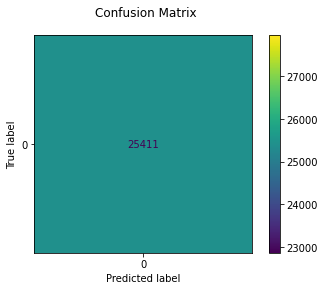

Classification report for classifier DecisionTreeClassifier(class_weight={0: 2.0, 1: 1.0},
                       min_impurity_decrease=0.0001, min_samples_split=20,
                       random_state=0):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     25411

    accuracy                           1.00     25411
   macro avg       1.00      1.00      1.00     25411
weighted avg       1.00      1.00      1.00     25411




In [ ]:
# result for generating output shape file
# DT using cross_validation

X = nominal_data[nominal_features]
y = nominal_data["official_type"]
#weights = 'balanced'
weights = {0:2.0, 1:1.0}
dt = DecisionTreeClassifier(class_weight=weights,min_samples_split=20, random_state=0,min_impurity_decrease = 0.0001)
y_pred = cross_val_predict(dt, X, y, cv=10)
disp = metrics.ConfusionMatrixDisplay.from_predictions(y, y_pred)
disp.figure_.suptitle("Confusion Matrix")
print(f"Confusion matrix:\n{disp.confusion_matrix}")

plt.show()

print(
    f"Classification report for classifier {dt}:\n"
    f"{metrics.classification_report(y, y_pred)}\n"
)

In [ ]:
output_data = nominal_data.copy()
output_data.drop(columns=['official_type','buffer_cat2_30', 'buffer_cat2_60','buffer_cat2_90'], inplace=True)
output_data.insert(1,'official',y)
output_data.insert(2,'predicted',y_pred)
output_filtered = output_data.copy()
#output_filtered = output_filtered[output_filtered['official'] != output_filtered['predicted']]
output_filtered['official'] = \
    output_filtered['official'].apply(lambda x: 'RES' if x == 1 else 'NON_RES')
output_filtered['predicted'] = \
    output_filtered['predicted'].apply(lambda x: 'RES' if x == 1 else 'NON_RES')

In [ ]:
#output_filtered.to_file("./Datasets/OSM/Geopandas_Output/filtered_output.shp")

if "Bhopal_Predictions" not in os.listdir("/DATA2/dse313/group15/Bhopal/"):
    os.mkdir("/DATA2/dse313/group15/Bhopal/Bhopal_Predictions/")
output_data.to_file("/DATA2/dse313/group15/Bhopal/Bhopal_Predictions/Bhopal_Predictions.shp")

<ipython-input-206-27051ebe0bd1>:5: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  output_data.to_file("/DATA2/dse313/group15/Bhopal/Bhopal_Predictions/Bhopal_Predictions.shp")


Confusion matrix:
[[ 10181      0]
 [194490      0]]


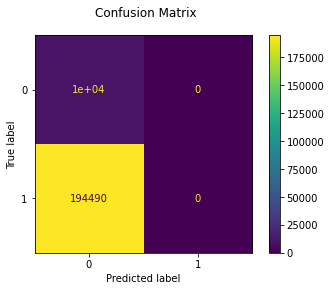

Classification report for classifier DecisionTreeClassifier(class_weight={0: 2.0, 1: 1.0},
                       min_impurity_decrease=0.0001, min_samples_split=20,
                       random_state=0):
              precision    recall  f1-score   support

           0       0.05      1.00      0.09     10181
           1       0.00      0.00      0.00    194490

    accuracy                           0.05    204671
   macro avg       0.02      0.50      0.05    204671
weighted avg       0.00      0.05      0.00    204671




/home/dse313/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dse313/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dse313/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Test on FFX 100%

X = nominal_data[nominal_features]
y = nominal_data["official_type"]

FFX_nominal = pd.read_pickle("/DATA2/dse313/group15/FFX/FFX_Processed_Data/FFX_nominal_data.pkl")

FFX_X = FFX_nominal[nominal_features]
FFX_y = FFX_nominal["official_type"]

# Split data into 80% train and 20% test subsets
X_train, X_test, y_train, y_test = train_test_split(\
    X, y, test_size=0.2, shuffle=True)

#weights = 'balanced'
weights = {0:2.0, 1:1.0}
dt_split = DecisionTreeClassifier(class_weight=weights,min_samples_split=20, \
                                random_state=0,min_impurity_decrease = 0.0001)

#dt_split = DecisionTreeClassifier(min_samples_split=20, random_state=0,min_impurity_decrease = 0.0001)

# Learn on the train subset
dt_split.fit(X_train, y_train)

# Predict the target on the test subset
predicted = dt_split.predict(FFX_X)

# 1 = RES; 0 = NON_RES

disp = metrics.ConfusionMatrixDisplay.from_predictions(FFX_y, predicted)
disp.figure_.suptitle("Confusion Matrix")
print(f"Confusion matrix:\n{disp.confusion_matrix}")

plt.show()

print(
    f"Classification report for classifier {dt_split}:\n"
    f"{metrics.classification_report(FFX_y, predicted)}\n")

Confusion matrix:
[[ 450    0]
 [4164    0]]


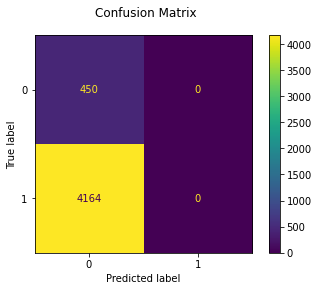

Classification report for classifier DecisionTreeClassifier(class_weight={0: 2.0, 1: 1.0},
                       min_impurity_decrease=0.0001, min_samples_split=20,
                       random_state=0):
              precision    recall  f1-score   support

           0       0.10      1.00      0.18       450
           1       0.00      0.00      0.00      4164

    accuracy                           0.10      4614
   macro avg       0.05      0.50      0.09      4614
weighted avg       0.01      0.10      0.02      4614




/home/dse313/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dse313/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dse313/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Test on Boulder 20% data

Boulder_nominal = pd.read_pickle("/DATA2/dse313/group15/Boulder/Boulder_Processed_Data/Boulder_nominal_data.pkl")

X = nominal_data[nominal_features]
y = nominal_data["official_type"]

#Boulder_X = pd.read_pickle("./Boulder_Processed_Data/Boulder_X.pkl")
#Boulder_y = pd.read_pickle("./Boulder_Processed_Data/Boulder_y.pkl")

Boulder_X = Boulder_nominal[nominal_features]
Boulder_y = Boulder_nominal["official_type"]

# Split data into 80% train and 20% test subsets
X_train, X_test, y_train, y_test = train_test_split(\
    X, y, test_size=0.2, shuffle=True)

Boulder_X_train, Boulder_X_test, Boulder_y_train, Boulder_y_test = train_test_split(\
    Boulder_X, Boulder_y, test_size=0.2, shuffle=True)

#weights = 'balanced'
weights = {0:2.0, 1:1.0}
dt_split = DecisionTreeClassifier(class_weight=weights,min_samples_split=20, \
                                random_state=0,min_impurity_decrease = 0.0001)

#dt_split = DecisionTreeClassifier(min_samples_split=20, random_state=0,min_impurity_decrease = 0.0001)

# Learn on the train subset
dt_split.fit(X_train, y_train)

# Predict the target on the test subset
predicted = dt_split.predict(Boulder_X_test)

# 1 = RES; 0 = NON_RES

disp = metrics.ConfusionMatrixDisplay.from_predictions(Boulder_y_test, predicted)
disp.figure_.suptitle("Confusion Matrix")
print(f"Confusion matrix:\n{disp.confusion_matrix}")

plt.show()

print(
    f"Classification report for classifier {dt_split}:\n"
    f"{metrics.classification_report(Boulder_y_test, predicted)}\n"
)

Confusion matrix:
[[ 2382     0]
 [20687     0]]


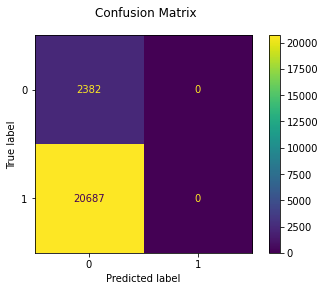

Classification report for classifier DecisionTreeClassifier(class_weight={0: 2.0, 1: 1.0},
                       min_impurity_decrease=0.0001, min_samples_split=20,
                       random_state=0):
              precision    recall  f1-score   support

           0       0.10      1.00      0.19      2382
           1       0.00      0.00      0.00     20687

    accuracy                           0.10     23069
   macro avg       0.05      0.50      0.09     23069
weighted avg       0.01      0.10      0.02     23069




/home/dse313/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dse313/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dse313/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Test on Boulder 100% data

Boulder_nominal = pd.read_pickle("/DATA2/dse313/group15/Boulder/Boulder_Processed_Data/Boulder_nominal_data.pkl")

X = nominal_data[nominal_features]
y = nominal_data["official_type"]

Boulder_X = Boulder_nominal[nominal_features]
Boulder_y = Boulder_nominal["official_type"]

#weights = 'balanced'
weights = {0:2.0, 1:1.0}
dt_split = DecisionTreeClassifier(class_weight=weights,min_samples_split=20, \
                                random_state=0,min_impurity_decrease = 0.0001)

X_train, X_test, y_train, y_test = train_test_split(\
    X, y, test_size=0.2, shuffle=True)

# Learn on FFX
dt_split.fit(X_train, y_train)

# Predict the target on Boulder
predicted = dt_split.predict(Boulder_X)

# 1 = RES; 0 = NON_RES

disp = metrics.ConfusionMatrixDisplay.from_predictions(Boulder_y, predicted)
disp.figure_.suptitle("Confusion Matrix")
print(f"Confusion matrix:\n{disp.confusion_matrix}")

plt.show()

print(
    f"Classification report for classifier {dt_split}:\n"
    f"{metrics.classification_report(Boulder_y, predicted)}\n"
)

In [ ]:
output_data = Boulder_nominal.copy()
output_data.drop(columns=['official_type','buffer_cat2_30', 'buffer_cat2_60','buffer_cat2_90'], inplace=True)
output_data.insert(1,'official',Boulder_y)
output_data.insert(2,'predicted',predicted)

In [ ]:
output_data.head()

,geometry,official,predicted,buffer_cat1_30,buffer_cat1_60,buffer_cat1_90,buffer_cat3_30,buffer_cat3_60,buffer_cat3_90,buffer_cat4_30,...,yes,cemetery_landuse,construction_landuse,farmyard_landuse,forest_landuse,misc_landuse,no_landuse,non_res_landuse,recreation_ground_landuse,residential_landuse
0,"POLYGON ((-105.26620 40.00586, -105.26620 40.0...",1,0,1,1,1,1,1,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,"POLYGON ((-105.26486 40.00597, -105.26486 40.0...",1,0,0,0,1,1,1,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,"POLYGON ((-105.26486 40.00602, -105.26469 40.0...",1,0,0,1,1,1,1,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,"POLYGON ((-105.26461 40.00653, -105.26441 40.0...",1,0,0,0,1,1,1,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,"POLYGON ((-105.26530 40.00707, -105.26515 40.0...",1,0,0,1,1,1,1,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [ ]:
#output_filtered.to_file("./Datasets/OSM/Geopandas_Output/filtered_output.shp")
if 'Test_on_Boulder' not in os.listdir("/DATA2/dse313/group15/Bhopal/"):
    os.mkdir("/DATA2/dse313/group15/Bhopal/Test_on_Boulder")
output_data.to_file("/DATA2/dse313/group15/Bhopal/Test_on_Boulder/Boulder_Test_Predictions.shp")

<ipython-input-212-5ed056411806>:4: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  output_data.to_file("/DATA2/dse313/group15/Bhopal/Test_on_Boulder/Boulder_Test_Predictions.shp")


In [ ]:
#X.to_pickle("./FFX_Processed_Data/FFX_X.pkl")
#y.to_pickle("./FFX_Processed_Data/FFX_y.pkl")
if 'Bhopal_Processed_Data' not in os.listdir("/DATA2/dse313/group15/Bhopal/"):
    os.mkdir("/DATA2/dse313/group15/Bhopal/Bhopal_Processed_Data")
nominal_data.to_pickle("/DATA2/dse313/group15/Bhopal/Bhopal_Processed_Data/Bhopal_nominal_data.pkl")

In [ ]:
# Ablation Study

In [ ]:
input_data.columns

Index(['geometry', 'official_type', 'buffer_cat1_30', 'buffer_cat1_60',
       'buffer_cat1_90', 'buffer_cat2_30', 'buffer_cat2_60', 'buffer_cat2_90',
       'buffer_cat3_30', 'buffer_cat3_60', 'buffer_cat3_90', 'buffer_cat4_30',
       'buffer_cat4_60', 'buffer_cat4_90', 'shop', 'website', 'brand',
       'amenity', 'building:levels', 'name', 'addr:street', 'source',
       'building', 'landuse', 'area', 'parking_cat1', 'parking_cat2',
       'parking_cat3', 'parking_cat4', 'parking_cat5', 'parking_cat6',
       'parking_cat7', 'parking_cat8', 'parking_cat9'],
      dtype='object')

In [ ]:
ablation_data = input_data.copy()

In [ ]:
ablation_data.drop(columns=['buffer_cat1_30', 'buffer_cat1_60',\
                        'buffer_cat1_90', 'buffer_cat2_30', 'buffer_cat2_60', 'buffer_cat2_90',\
                        'buffer_cat3_30', 'buffer_cat3_60', 'buffer_cat3_90', 'buffer_cat4_30',\
                        'buffer_cat4_60', 'buffer_cat4_90',\
                        \
                        \
                        'parking_cat1', 'parking_cat2', 'parking_cat3', 'parking_cat4',\
                        'parking_cat5', 'parking_cat6', 'parking_cat7', 'parking_cat8',\
                        'parking_cat9'], inplace=True)

In [ ]:
ablation_data.columns

Index(['geometry', 'official_type', 'shop', 'website', 'brand', 'amenity',
       'building:levels', 'name', 'addr:street', 'source', 'building',
       'landuse', 'area'],
      dtype='object')

In [ ]:
# nominal transform

value_tags = ['building','landuse']
#nominal_data = input_data.copy()
#value_tags = ['building']
ablation_data = nominal_transform(ablation_data, value_tags)
ablation_features = list(ablation_data.columns[2:])
ablation_features

/home/dse313/.local/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/dse313/.local/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


['shop',
 'website',
 'brand',
 'amenity',
 'building:levels',
 'name',
 'addr:street',
 'source',
 'area',
 'apartments',
 'commercial',
 'hospital',
 'house',
 'industrial',
 'misc_buildings',
 'residential',
 'roof',
 'school',
 'shed',
 'yes',
 'misc_landuse',
 'no_landuse',
 'non_res_landuse',
 'recreation_ground_landuse',
 'residential_landuse']

In [ ]:
ablation_data.columns

Index(['geometry', 'official_type', 'shop', 'website', 'brand', 'amenity',
       'building:levels', 'name', 'addr:street', 'source', 'area',
       'apartments', 'commercial', 'hospital', 'house', 'industrial',
       'misc_buildings', 'residential', 'roof', 'school', 'shed', 'yes',
       'misc_landuse', 'no_landuse', 'non_res_landuse',
       'recreation_ground_landuse', 'residential_landuse'],
      dtype='object')

In [ ]:
ablation_data.shape

(25411, 27)

Confusion matrix:
[[5083]]


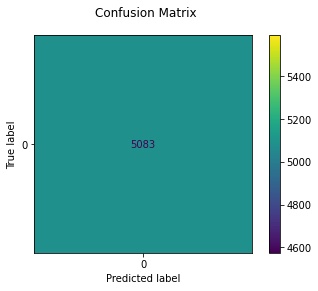

Classification report for classifier DecisionTreeClassifier(class_weight={0: 2.0, 1: 1.0},
                       min_impurity_decrease=0.0001, min_samples_split=20,
                       random_state=0):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5083

    accuracy                           1.00      5083
   macro avg       1.00      1.00      1.00      5083
weighted avg       1.00      1.00      1.00      5083




In [ ]:
X = ablation_data[ablation_features]
y = ablation_data["official_type"]
weights = {0:2.0, 1:1.0}

# Split data into 80% train and 20% test subsets
X_train, X_test, y_train, y_test = train_test_split(\
    X, y, test_size=0.2, shuffle=True)
dt_split = DecisionTreeClassifier(class_weight=weights,min_samples_split=20, \
                                random_state=0,min_impurity_decrease = 0.0001)

#dt_split = DecisionTreeClassifier(min_samples_split=20, random_state=0,min_impurity_decrease = 0.0001)

# Learn on the train subset
dt_split.fit(X_train, y_train)

# Predict the target on the test subset
predicted = dt_split.predict(X_test)

# 1 = RES; 0 = NON_RES

disp = metrics.ConfusionMatrixDisplay.from_predictions(y_test, predicted)
disp.figure_.suptitle("Confusion Matrix")
print(f"Confusion matrix:\n{disp.confusion_matrix}")

plt.show()

print(
    f"Classification report for classifier {dt_split}:\n"
    f"{metrics.classification_report(y_test, predicted)}\n"
)